## Lab 2.4: Platki sniadaniowe - klasyfikacja

### Paczki i dane

In [23]:
# Basic paczki do analizy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Paczki do klasyfikacji i modelowania
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from matplotlib.gridspec import GridSpec
from sklearn.metrics import classification_report, confusion_matrix

# Klasyfikatory
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectFromModel
import warnings

warnings.filterwarnings('ignore')
import os

if not os.path.exists('Płatki-sniadaniowe-cereals.txt'):
    raise FileNotFoundError("Plik 'Płatki-sniadaniowe-cereals.txt' nie został znaleziony.")

In [24]:
# Ustawienia dla wykresów
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.family'] = 'DejaVu Sans'

# Wczytanie danych
df = pd.read_csv('Płatki-sniadaniowe-cereals.txt', sep='\t')

# Definicja zmiennych do analizy
nutrients = ['kalorie', 'cukry', 'weglowodany', 'proteiny', 'tluszcz', 'blonnik', 'sod', 'potas']
nutrient_names = ['Kalorie', 'Cukry', 'Węglowodany', 'Proteiny', 'Tłuszcz', 'Błonnik', 'Sód', 'Potas']

## Analiza danych - wykresy


### Wykresy skrzypcowe

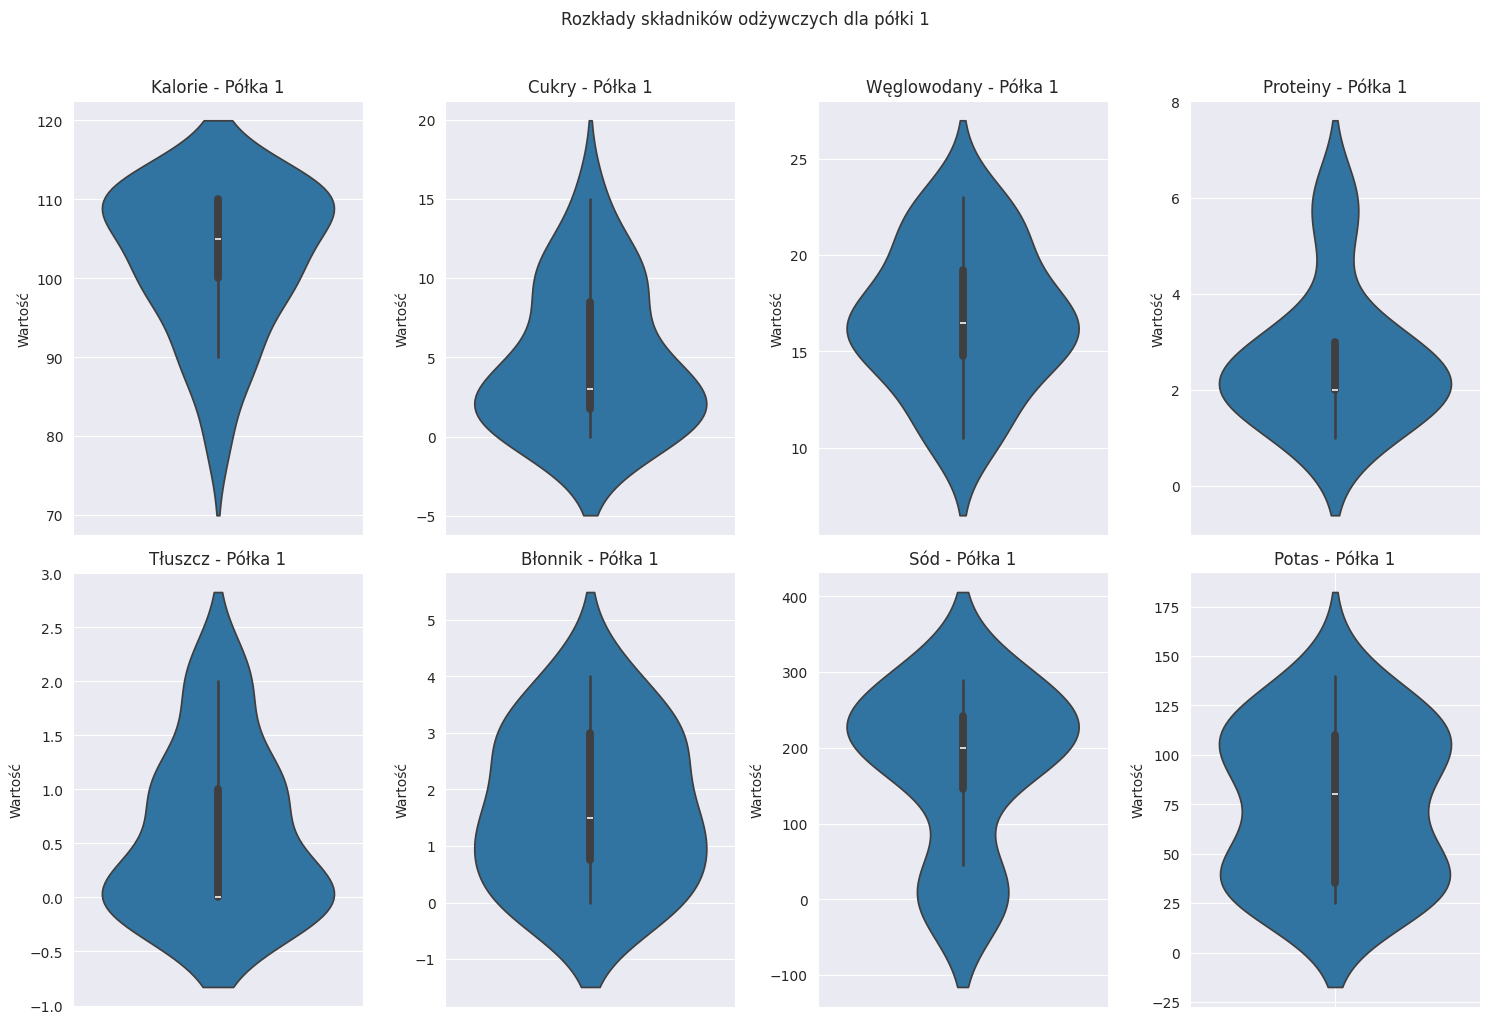

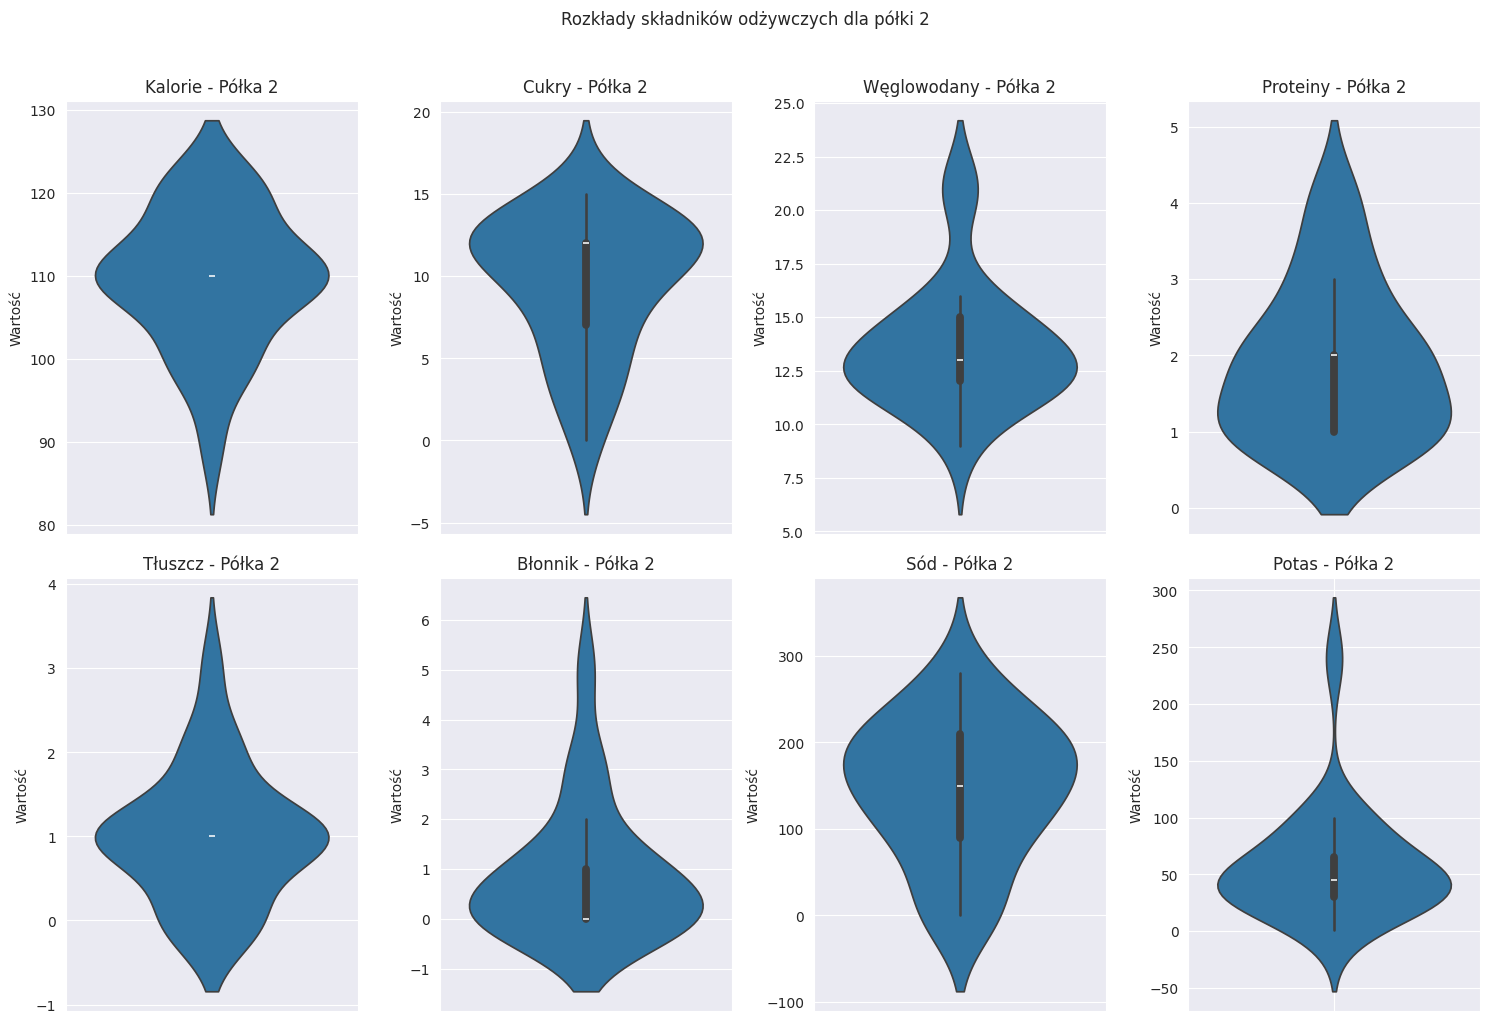

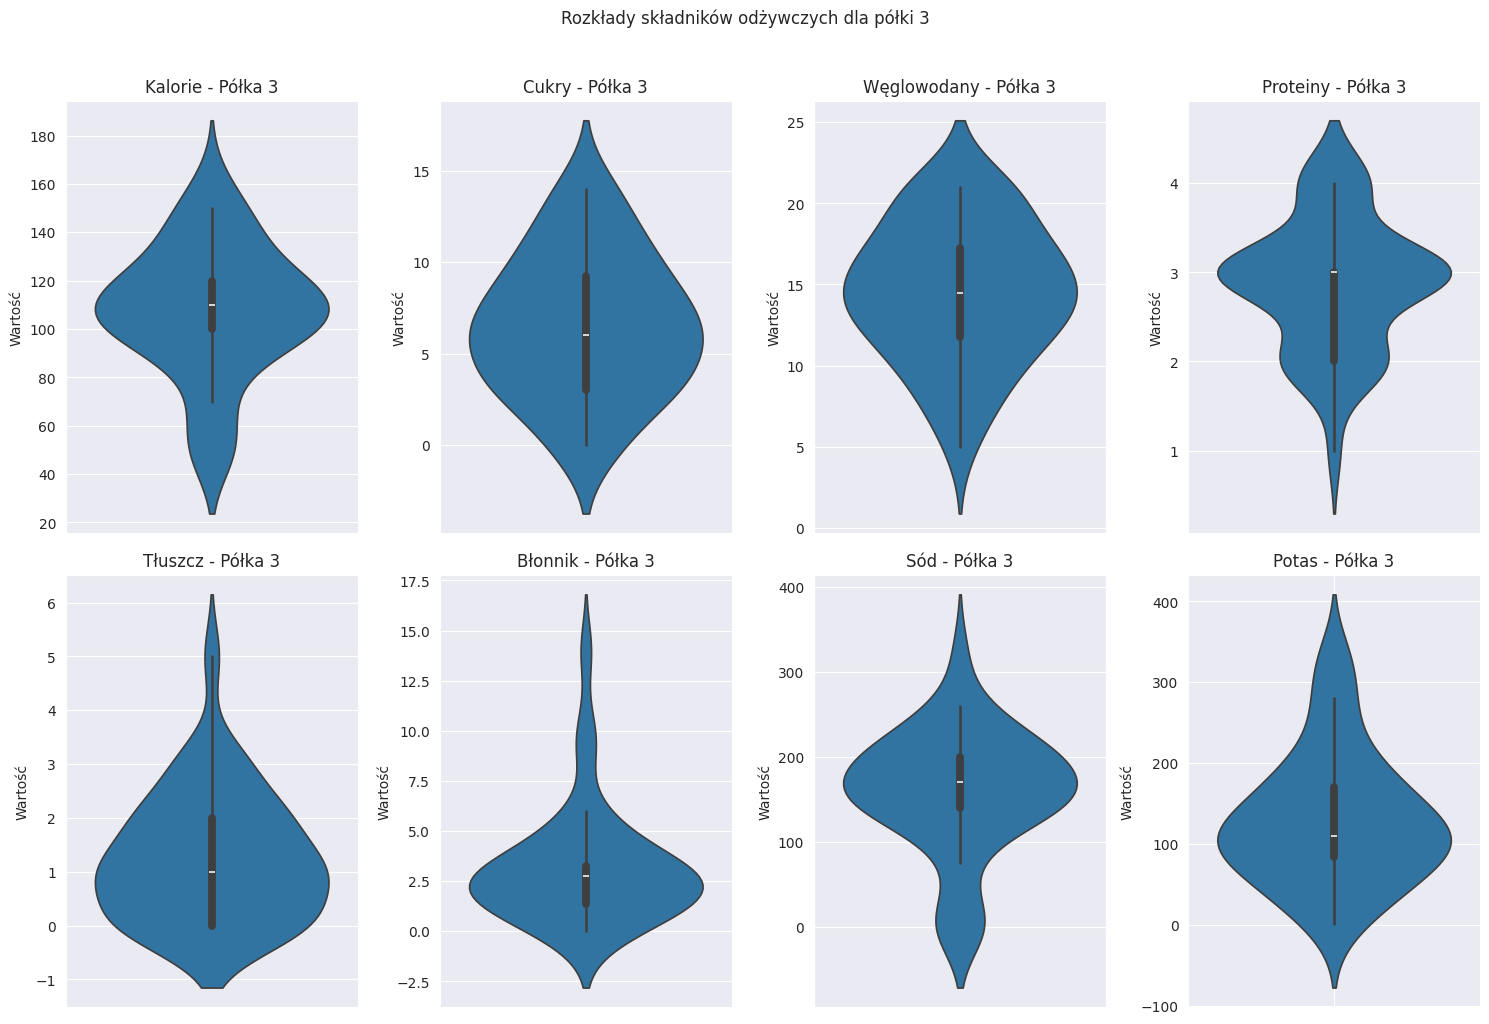

In [25]:
def create_detailed_violin_plots():
    # Tworzymy osobny wykres dla każdej półki
    for shelf in sorted(df['Liczba_polek'].unique()):
        shelf_data = df[df['Liczba_polek'] == shelf]

        plt.figure(figsize=(15, 10))
        for i, (nutrient, name) in enumerate(zip(nutrients, nutrient_names)):
            plt.subplot(2, 4, i + 1)
            sns.violinplot(y=nutrient, data=shelf_data, inner='box')
            plt.title(f'{name} - Półka {shelf}')
            plt.ylabel('Wartość')

        plt.suptitle(f'Rozkłady składników odżywczych dla półki {shelf}', y=1.02)
        plt.tight_layout()
        plt.grid(True)
        plt.show()


create_detailed_violin_plots()

### Wykresy radarowe dla profilu odżywczego kazdej półki



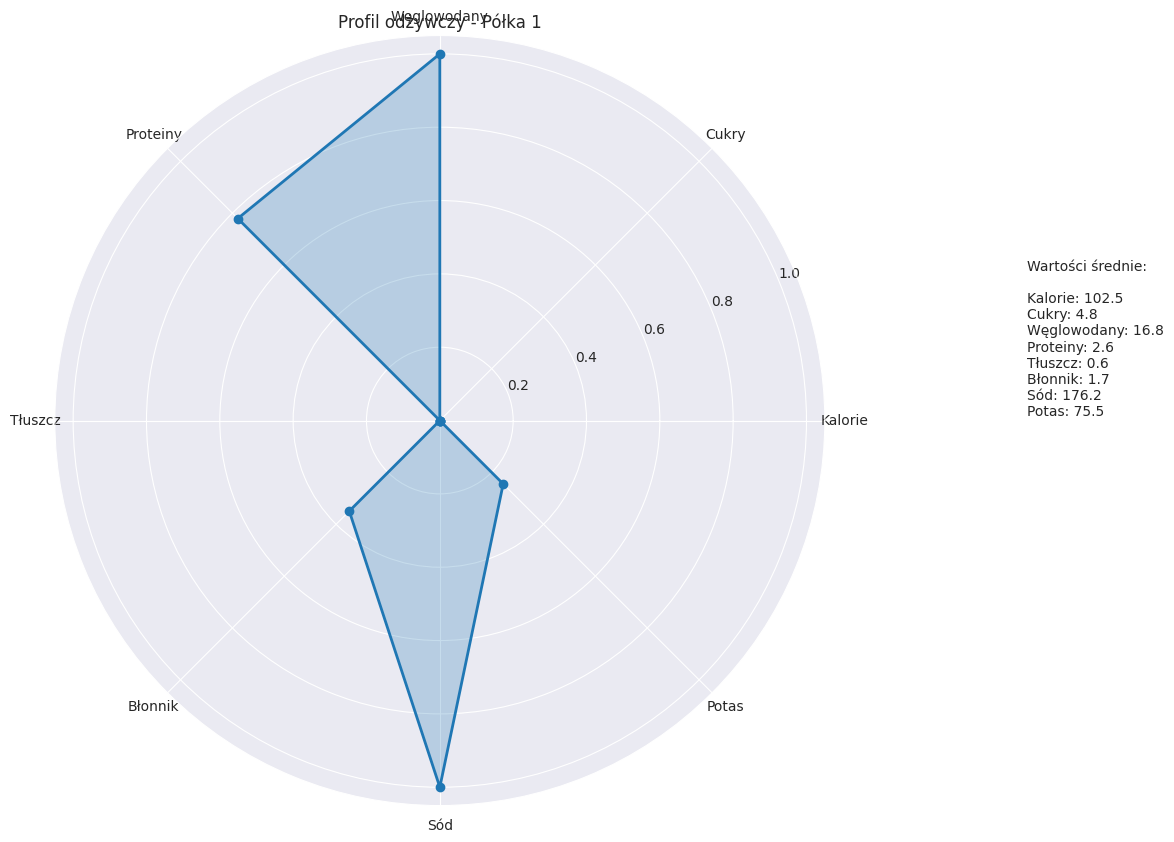

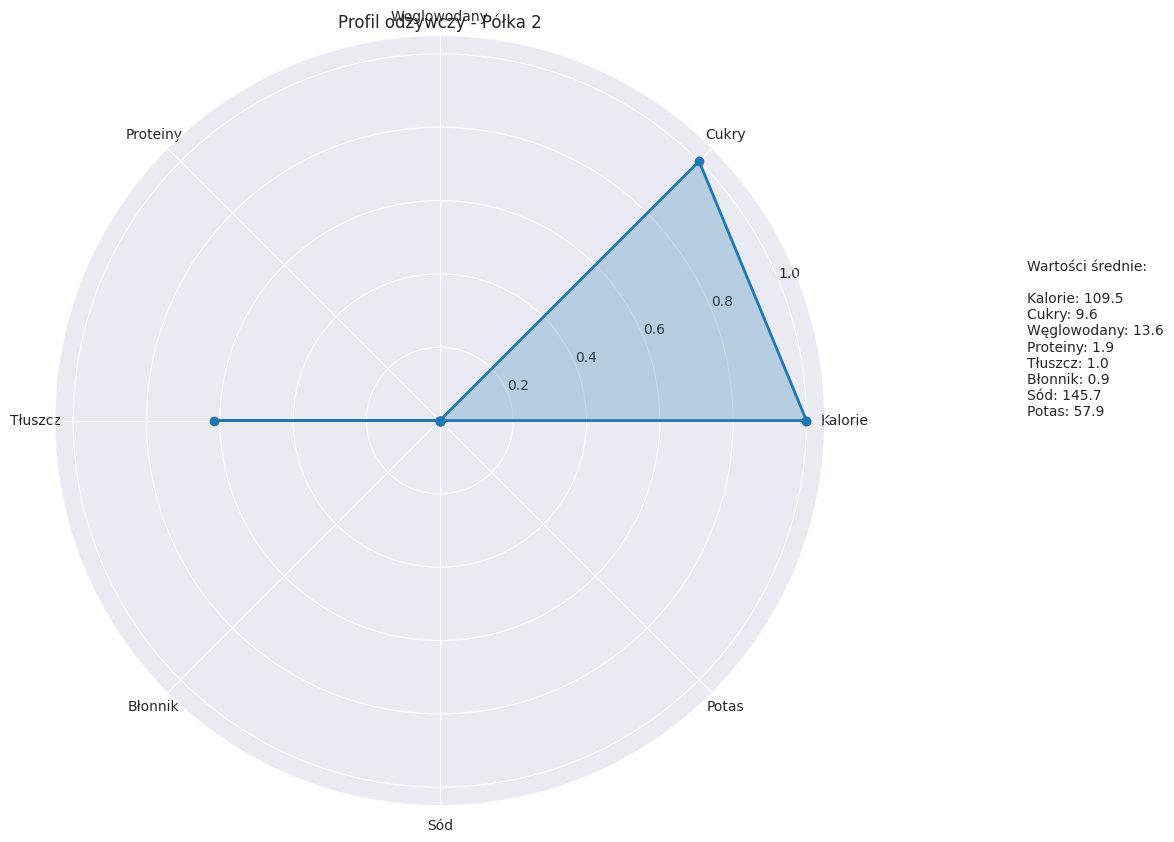

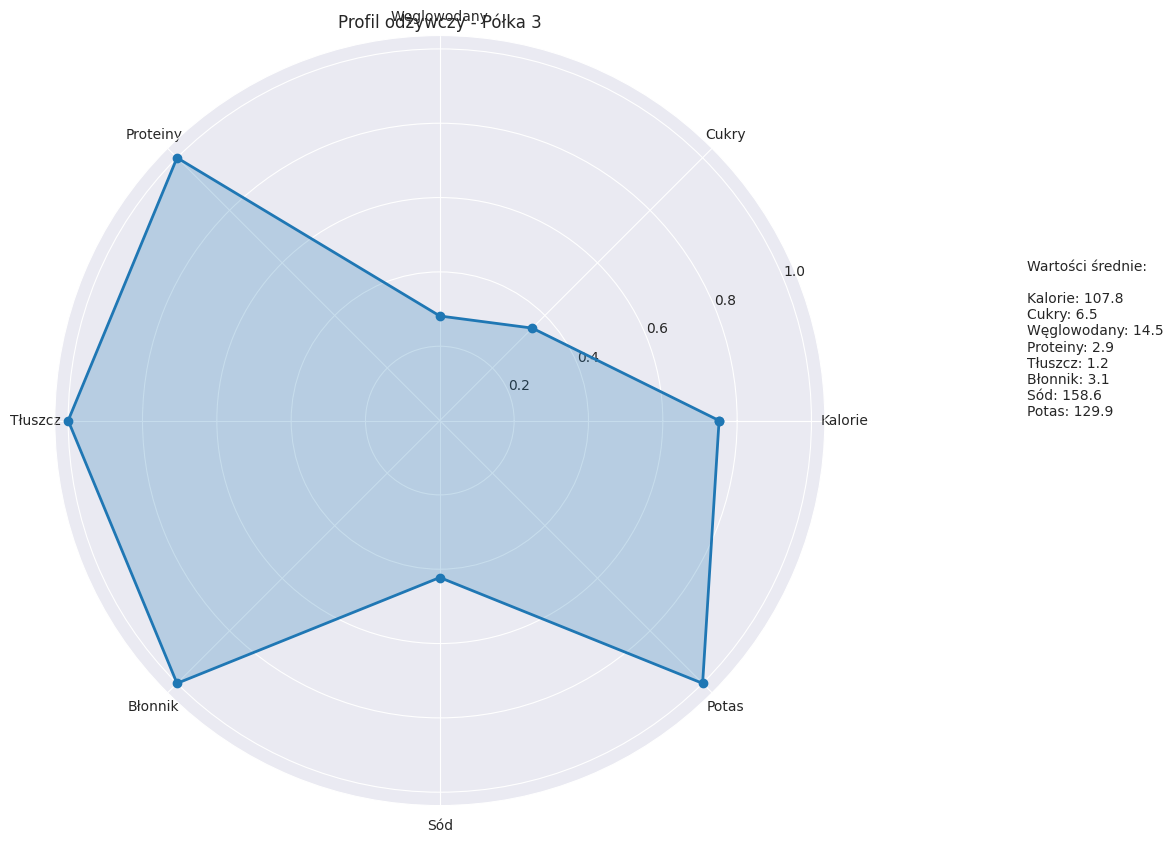

In [26]:
def create_radar_plots() -> None:
    # Tworzymy osobne wykresy dla każdej półki
    shelf_means = df.groupby('Liczba_polek')[nutrients].mean()

    # Normalizacja danych do 0,1 bo skala wartości jest różna
    shelf_means_norm = (shelf_means - shelf_means.min()) / (shelf_means.max() - shelf_means.min())

    # Linespace tworzy równo odległe wartości w zadanym przedziale
    angles = np.linspace(0, 2 * np.pi, len(nutrients), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # Zamknięcie pętli

    for shelf in sorted(df['Liczba_polek'].unique()):
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

        values = shelf_means_norm.loc[shelf].values
        values = np.concatenate((values, [values[0]]))  # Konkatenacja ktora zamyka pętlę

        # Rysowanie wykresu
        ax.plot(angles, values, 'o-', linewidth=2, label=f'Półka {shelf}')
        ax.fill(angles, values, alpha=0.25)

        # Ustawienie nazw osi
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(nutrient_names)

        plt.title(f'Profil odżywczy - Półka {shelf}')

        # Dodanie oryginalnych wartości
        orig_values = shelf_means.loc[shelf].round(1)
        legend_text = '\n'.join([f'{name}: {value}'
                                 for name, value in zip(nutrient_names, orig_values)])
        plt.figtext(1.1, 0.5, f'Wartości średnie:\n\n{legend_text}',
                    bbox=dict(facecolor='white', alpha=0.8))

        plt.show()


create_radar_plots()

### Analiza skladu wedlug producenta - top 5


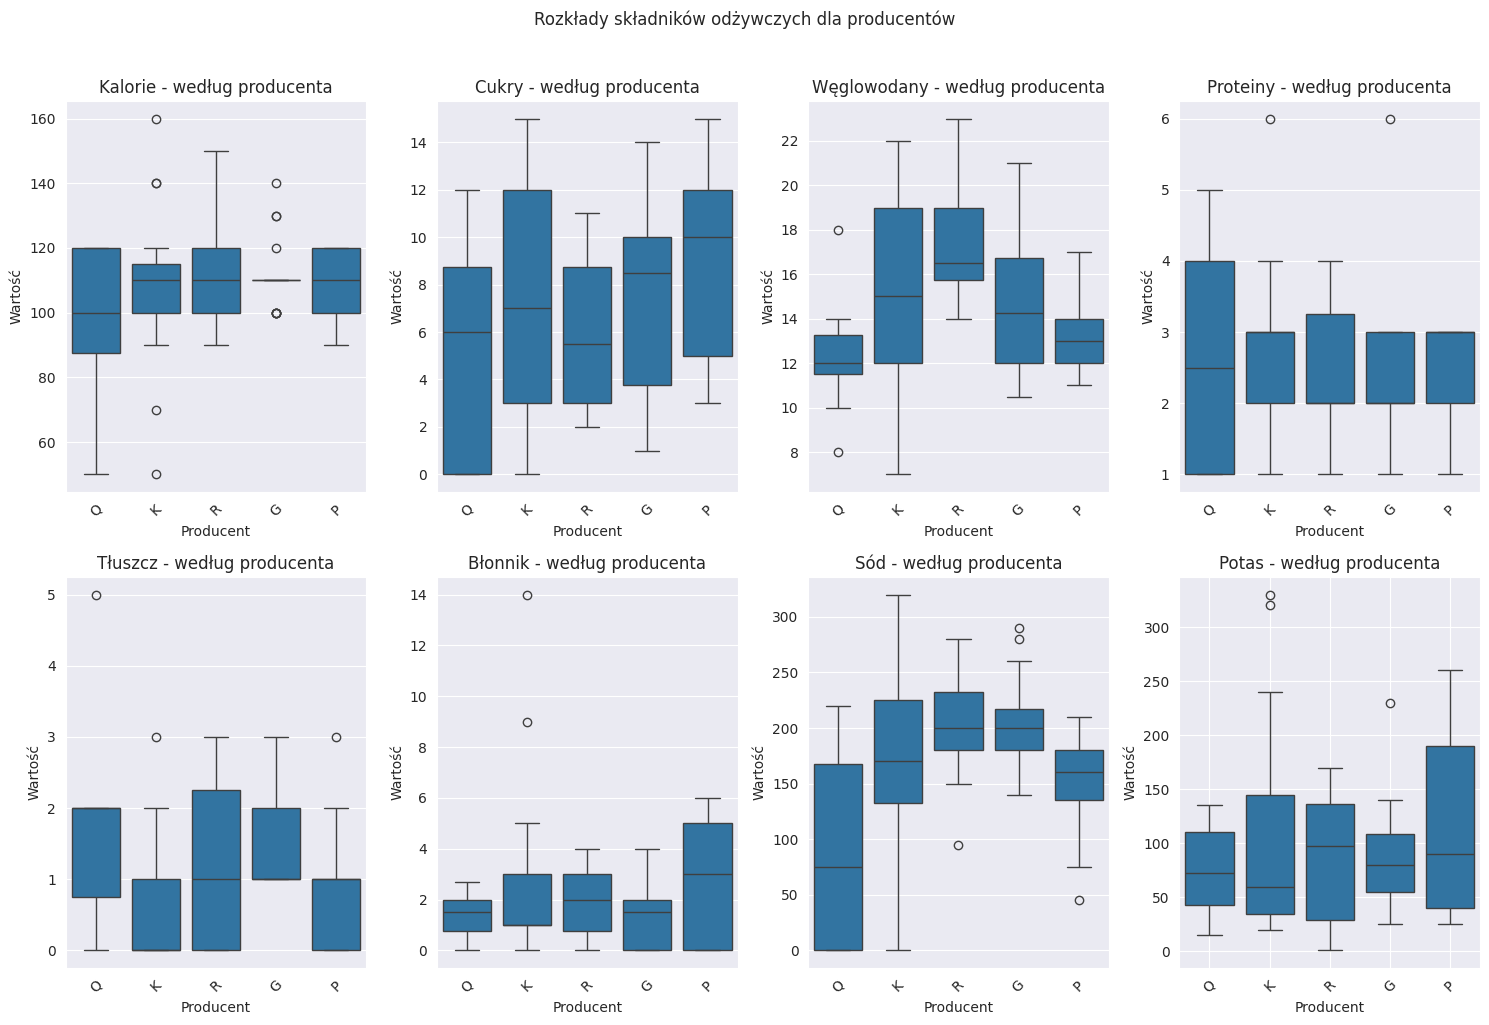

In [27]:
def analyze_by_manufacturer() -> None:
    # Grupowanie po producencie
    manufacturers = df['producent'].value_counts().head(5).index  # 5 najczęstszych producentów
    df_filtered = df[df['producent'].isin(manufacturers)]

    plt.figure(figsize=(15, 10))
    for i, (nutrient, name) in enumerate(zip(nutrients, nutrient_names)):
        plt.subplot(2, 4, i + 1)
        box_plot = sns.boxplot(x='producent', y=nutrient, data=df_filtered)
        plt.title(f'{name} - według producenta')
        plt.ylabel('Wartość')
        plt.xlabel('Producent')
        plt.xticks(rotation=45)

    plt.suptitle('Rozkłady składników odżywczych dla producentów', y=1.02)
    plt.tight_layout()
    plt.grid(True)
    plt.show()


analyze_by_manufacturer()

### Heatmapa srednich wartosci

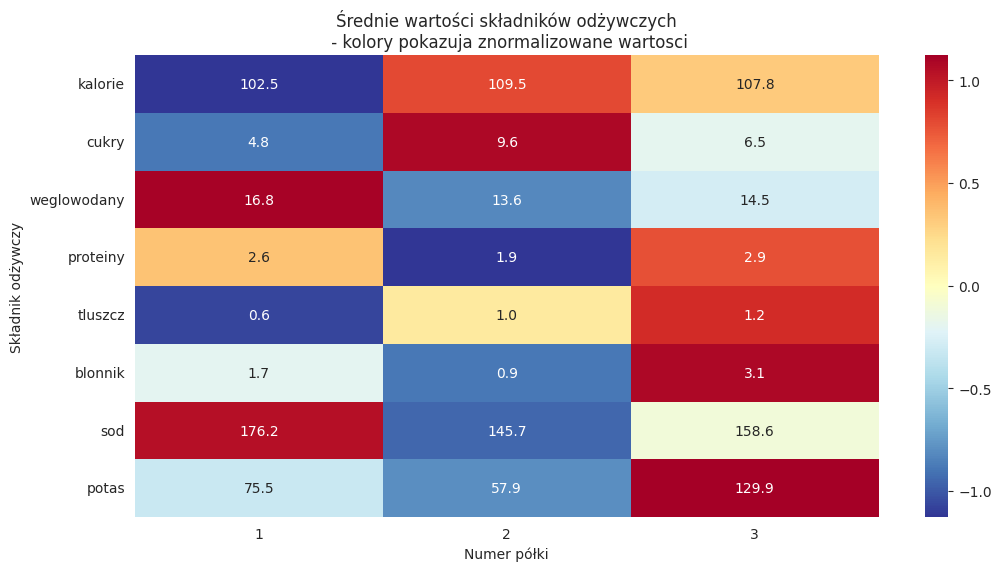

In [28]:
def create_nutrient_heatmap() -> None:
    shelf_means = df.groupby('Liczba_polek')[nutrients].mean()
    shelf_means_normalized = (shelf_means - shelf_means.mean()) / shelf_means.std()

    plt.figure(figsize=(12, 6))
    sns.heatmap(shelf_means_normalized.T,
                annot=shelf_means.T.round(1),
                fmt='.1f',
                cmap='RdYlBu_r',
                center=0)
    plt.title('Średnie wartości składników odżywczych\n - kolory pokazuja znormalizowane wartosci')
    plt.xlabel('Numer półki')
    plt.ylabel('Składnik odżywczy')
    plt.grid(True)
    plt.show()


create_nutrient_heatmap()

### Wykresy przedzialow srednich wartosci dla polek z 95% przedzialem ufności

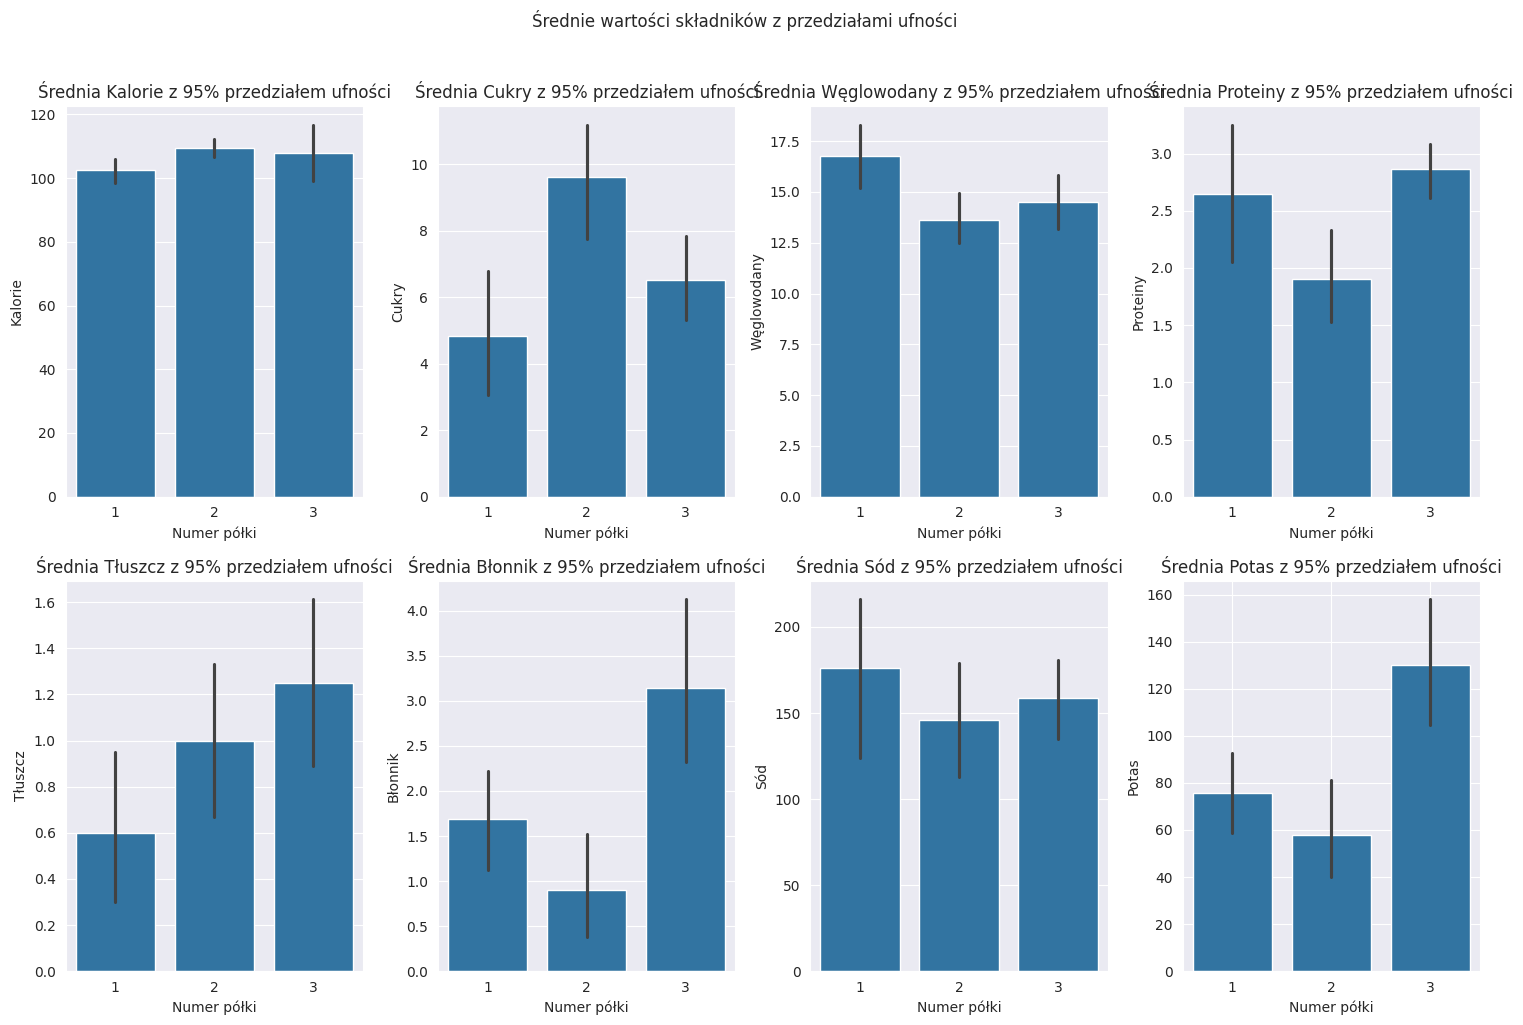

In [29]:
def plot_confidence_intervals() -> None:
    plt.figure(figsize=(15, 10))
    for i, (nutrient, name) in enumerate(zip(nutrients, nutrient_names)):
        plt.subplot(2, 4, i + 1)
        sns.barplot(x='Liczba_polek', y=nutrient, data=df, ci=95)
        plt.title(f'Średnia {name} z 95% przedziałem ufności')
        plt.xlabel('Numer półki')
        plt.ylabel(name)
    plt.suptitle('Średnie wartości składników z przedziałami ufności', y=1.02)
    plt.tight_layout()
    plt.grid(True)
    plt.show()


plot_confidence_intervals()

### Analiza korelacji miedzy potencjalnymi zmiennymi niezaleznymi

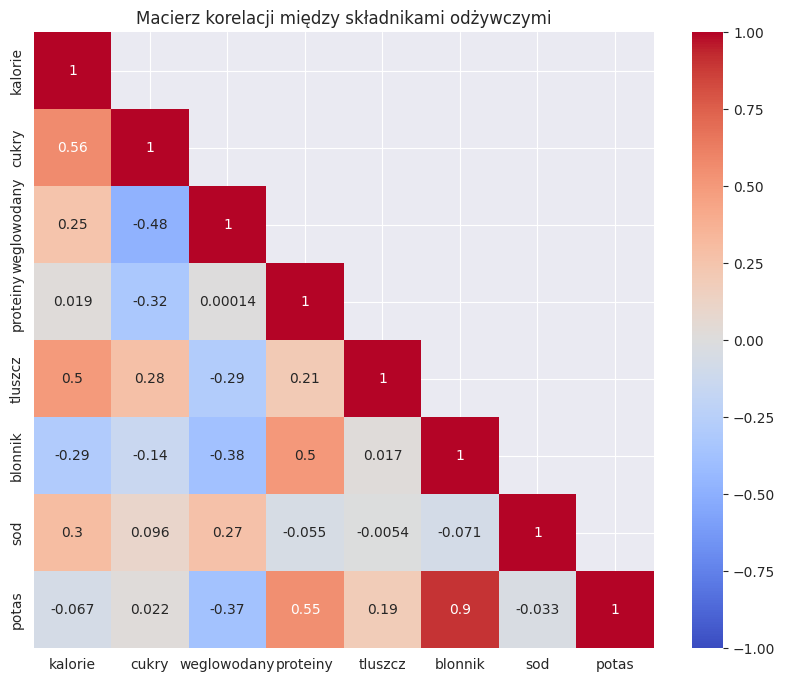

In [30]:
def plot_correlation_analysis() -> None:
    corr_matrix = df[nutrients].corr()  # Macierz korelacji

    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr_matrix), k=1)  # Maskowanie górnej trójkątnej macierzy
    sns.heatmap(corr_matrix,
                mask=mask,
                annot=True,
                cmap='coolwarm',
                vmin=-1,  # Skala korelacji od -1 do 1 
                vmax=1,
                center=0)
    plt.title('Macierz korelacji między składnikami odżywczymi')
    plt.show()


plot_correlation_analysis()

### Analiza statystyczna - testy statystyczne np. dla P-value

In [31]:
def detailed_statistical_analysis() -> None:
    print("\nSzczegółowa analiza statystyczna składników:")

    for nutrient, name in zip(nutrients, nutrient_names):
        print(f"\n{name}:")

        # Statystyki opisowe
        stats_by_shelf = (df.groupby('Liczba_polek')[nutrient]
                          .agg(['count', 'mean', 'std', 'min', 'max']))
        print("\nStatystyki według półek:")
        print(stats_by_shelf.round(2))

        # Test Kruskal-Wallis
        groups = [group for _, group in df.groupby('Liczba_polek')[nutrient]]
        h_stat, p_val = stats.kruskal(*groups)
        print(f"\nTest Kruskal-Wallis:")
        print(f"H-statistic = {h_stat:.2f}")
        print(f"p-value = {p_val:.4f}")


detailed_statistical_analysis()


Szczegółowa analiza statystyczna składników:

Kalorie:

Statystyki według półek:
              count    mean    std  min  max
Liczba_polek                                
1                20  102.50   9.10   80  110
2                21  109.52   8.05   90  120
3                36  107.78  26.95   50  160

Test Kruskal-Wallis:
H-statistic = 4.02
p-value = 0.1343

Cukry:

Statystyki według półek:
              count  mean   std  min  max
Liczba_polek                             
1                20  4.85  4.51    0   15
2                21  9.62  4.13    0   15
3                36  6.53  3.84    0   14

Test Kruskal-Wallis:
H-statistic = 13.01
p-value = 0.0015

Węglowodany:

Statystyki według półek:
              count   mean   std   min   max
Liczba_polek                                
1                20  16.75  3.64  10.5  23.0
2                21  13.62  2.94   9.0  21.0
3                36  14.50  4.21   5.0  21.0

Test Kruskal-Wallis:
H-statistic = 8.10
p-value = 0.0175

Proteiny

In [32]:
# Podsumowanie analiz
print("\nPodstawowe wnioski z analizy:")
for nutrient in nutrients:
    shelf_means = df.groupby('Liczba_polek')[nutrient].mean()  # Średnie wartości składników
    max_shelf = shelf_means.idxmax()
    min_shelf = shelf_means.idxmin()
    diff_percent = ((shelf_means[max_shelf] - shelf_means[min_shelf]) / shelf_means[min_shelf] * 100).round(2)

    print(f"\n{nutrient.capitalize()}:")
    print(f"- Różnica między półkami: {diff_percent:.1f}%")
    print(f"- Najwyższa średnia (półka {max_shelf}): {shelf_means[max_shelf]:.2f}")
    print(f"- Najniższa średnia (półka {min_shelf}): {shelf_means[min_shelf]:.2f}")


Podstawowe wnioski z analizy:

Kalorie:
- Różnica między półkami: 6.8%
- Najwyższa średnia (półka 2): 109.52
- Najniższa średnia (półka 1): 102.50

Cukry:
- Różnica między półkami: 98.3%
- Najwyższa średnia (półka 2): 9.62
- Najniższa średnia (półka 1): 4.85

Weglowodany:
- Różnica między półkami: 23.0%
- Najwyższa średnia (półka 1): 16.75
- Najniższa średnia (półka 2): 13.62

Proteiny:
- Różnica między półkami: 50.2%
- Najwyższa średnia (półka 3): 2.86
- Najniższa średnia (półka 2): 1.90

Tluszcz:
- Różnica między półkami: 108.3%
- Najwyższa średnia (półka 3): 1.25
- Najniższa średnia (półka 1): 0.60

Blonnik:
- Różnica między półkami: 246.9%
- Najwyższa średnia (półka 3): 3.14
- Najniższa średnia (półka 2): 0.90

Sod:
- Różnica między półkami: 21.0%
- Najwyższa średnia (półka 1): 176.25
- Najniższa średnia (półka 2): 145.71

Potas:
- Różnica między półkami: 124.3%
- Najwyższa średnia (półka 3): 129.89
- Najniższa średnia (półka 2): 57.90


## Klasyfikator dla polki srodkowej oraz dla wszystkich pol, metodami: 
#### - KNN
#### - Naive Bayes
#### - Random Forest

### Kalkulator metryki danego klasyfikatora - funckja pomocnicza

In [33]:
def calculate_metrics(conf_matrix: np.ndarray, model_name="") -> dict:
    """
    Oblicza i wyświetla wszystkie metryki dla danego klasyfikatora
    """

    # Wyciągnięcie wartości z macierzy
    TN, FP, FN, TP = conf_matrix.ravel()

    # Basic metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0  # precyzja
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0  # czułość
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # swoistość

    # F1 score mowi nam o zbalansowaniu pomiedzy precyzja i czułością
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Advanced metrics
    # Matthews Correlation Coefficient (MCC) mowi nam o zależności pomiedzy obserwowanymi i przewidywanymi wartościami
    mcc_numerator = (TP * TN) - (FP * FN)  # licznik współczynnika korelacji Matthews
    mcc_denominator = np.sqrt(
        (TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))  # mianownik współczynnika korelacji Matthews
    mcc = mcc_numerator / mcc_denominator if mcc_denominator != 0 else 0

    balanced_accuracy = (recall + specificity) / 2  # zbalansowana dokładność
    informedness = recall + specificity - 1  # informacyjność
    markedness = precision + specificity - 1 if specificity > 0 else 0  # znakowność

    print(f"\n=== Metryki klasyfikacji {model_name} ===")
    print(f"Podstawowe metryki:")
    print(f"- Dokładność (Accuracy) = {accuracy:.3f}")
    print(f"- Precyzja (Precision) = {precision:.3f}")
    print(f"- Czułość (Recall/Sensitivity) = {recall:.3f}")
    print(f"- Swoistość (Specificity) = {specificity:.3f}")
    print(f"- F1 Score = {f1_score:.3f}")

    print(f"\nZaawansowane metryki:")
    print(f"- Matthews Correlation Coefficient (MCC) = {mcc:.3f}")
    print(f"- Balanced Accuracy = {balanced_accuracy:.3f}")
    print(f"- Informedness (Youden's J) = {informedness:.3f}")
    print(f"- Markedness = {markedness:.3f}")

    print(f"\nWartości macierzy pomyłek:")
    print(f"- True Negatives (TN) = {TN}")
    print(f"- False Positives (FP) = {FP}")
    print(f"- False Negatives (FN) = {FN}")
    print(f"- True Positives (TP) = {TP}")
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'mcc': mcc,
        'balanced_accuracy': balanced_accuracy
    }


In [34]:
df = pd.read_csv('Płatki-sniadaniowe-cereals.txt', sep='\t')

print("=== Analiza danych wejściowych ===")
print(f"\nLiczba produktów: {len(df)}")
print("\nRozkład produktów na półkach:")
print(df[['polka_1', 'polka_2', 'polka_3']].sum())

=== Analiza danych wejściowych ===

Liczba produktów: 77

Rozkład produktów na półkach:
polka_1    20
polka_2    21
polka_3    36
dtype: int64


### Helper do trenowania i ewaluacji klasyfikatora

In [35]:
def train_and_evaluate_classifier(clf, X_train, X_test, y_train, y_test, classifier_name: str,
                                  is_simple_model=False):  # is_simple_model - model proponowany na podstawie wstepnej analizy danych
    """
    Trenuje i ewaluuje klasyfikator, zwraca metryki
    """
    try:
        # Cross-validation
        scores = cross_val_score(clf, X_train, y_train,
                                 cv=5)  # 5-krotna walidacja krzyżowa polegajaca na podziale zbioru na 5 podzbiorów
        print(
            f"\nWyniki walidacji krzyżowej dla klasyfikatora {classifier_name}: {scores.mean():.3f} (±{scores.std():.3f})")

        clf.fit(X_train, y_train)  # Trenowanie klasyfikatora
        y_pred = clf.predict(X_test)  # Predykcja

        # Obliczanie metryk
        print(f"\n=== Wyniki klasyfikacji dla {classifier_name} (zbior testowy) ===")
        print(classification_report(y_test, y_pred))

        conf_matrix = confusion_matrix(y_test, y_pred)
        metrics = calculate_metrics(conf_matrix, classifier_name)

        if is_simple_model:
            # Wizualizacja macierzy pomyłek
            plt.figure(figsize=(10, 8))
            df_cm = pd.DataFrame(conf_matrix,
                                 index=['Nie na środkowej', 'Na środkowej'],
                                 columns=['Przewidziano: Nie', 'Przewidziano: Tak']
                                 )
            sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'Macierz pomyłek dla klasyfikatora {classifier_name}')
            plt.ylabel('Prawdizwa wartość')
            plt.xlabel('Przewidywana wartość')
            plt.show()

        return clf, metrics  # Zwracamy klasyfikator i metryki

    except Exception as e:
        print(f"Wystąpił błąd podczas trenowania {classifier_name}: {str(e)}")
        return clf, None  # Zwracamy None w przypadku błędu

## Model 1: Klasyfikacja dla półki środkowej


=== Model 1: Klasyfikacja dla półki środkowej (cukier i kalorie) ===

=== Klasyfikator: Random Forest ===

Wyniki walidacji krzyżowej dla klasyfikatora Random Forest (Model 1 - środkowa półka): 0.804 (±0.112)

=== Wyniki klasyfikacji dla Random Forest (Model 1 - środkowa półka) (zbior testowy) ===
              precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       0.83      0.71      0.77         7

    accuracy                           0.81        16
   macro avg       0.82      0.80      0.81        16
weighted avg       0.81      0.81      0.81        16


=== Metryki klasyfikacji Random Forest (Model 1 - środkowa półka) ===
Podstawowe metryki:
- Dokładność (Accuracy) = 0.812
- Precyzja (Precision) = 0.833
- Czułość (Recall/Sensitivity) = 0.714
- Swoistość (Specificity) = 0.889
- F1 Score = 0.769

Zaawansowane metryki:
- Matthews Correlation Coefficient (MCC) = 0.618
- Balanced Accuracy = 0.802
- Informedness (Youden's J)

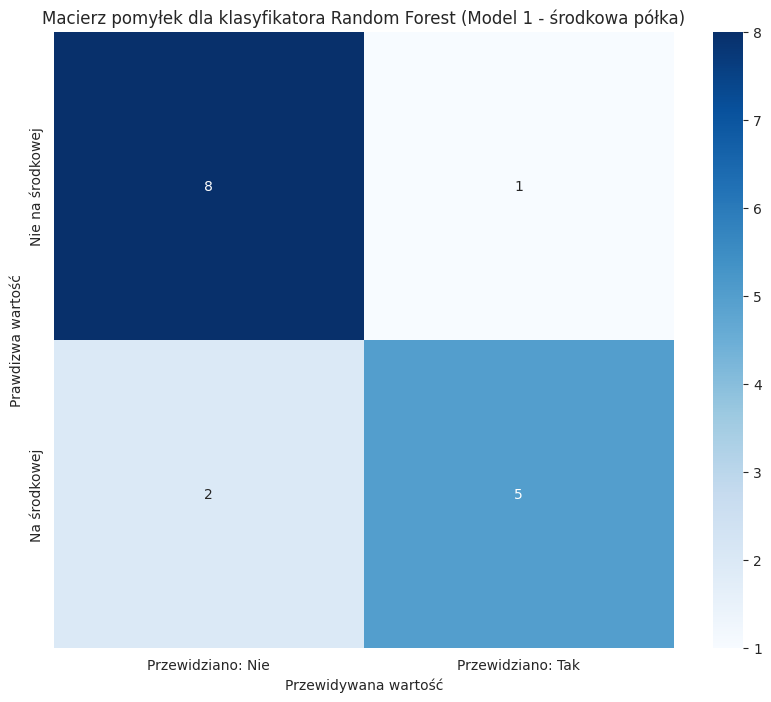


=== Klasyfikator: KNN ===

Wyniki walidacji krzyżowej dla klasyfikatora KNN (Model 1 - środkowa półka): 0.837 (±0.088)

=== Wyniki klasyfikacji dla KNN (Model 1 - środkowa półka) (zbior testowy) ===
              precision    recall  f1-score   support

           0       0.73      0.89      0.80         9
           1       0.80      0.57      0.67         7

    accuracy                           0.75        16
   macro avg       0.76      0.73      0.73        16
weighted avg       0.76      0.75      0.74        16


=== Metryki klasyfikacji KNN (Model 1 - środkowa półka) ===
Podstawowe metryki:
- Dokładność (Accuracy) = 0.750
- Precyzja (Precision) = 0.800
- Czułość (Recall/Sensitivity) = 0.571
- Swoistość (Specificity) = 0.889
- F1 Score = 0.667

Zaawansowane metryki:
- Matthews Correlation Coefficient (MCC) = 0.493
- Balanced Accuracy = 0.730
- Informedness (Youden's J) = 0.460
- Markedness = 0.689

Wartości macierzy pomyłek:
- True Negatives (TN) = 8
- False Positives (FP) = 1

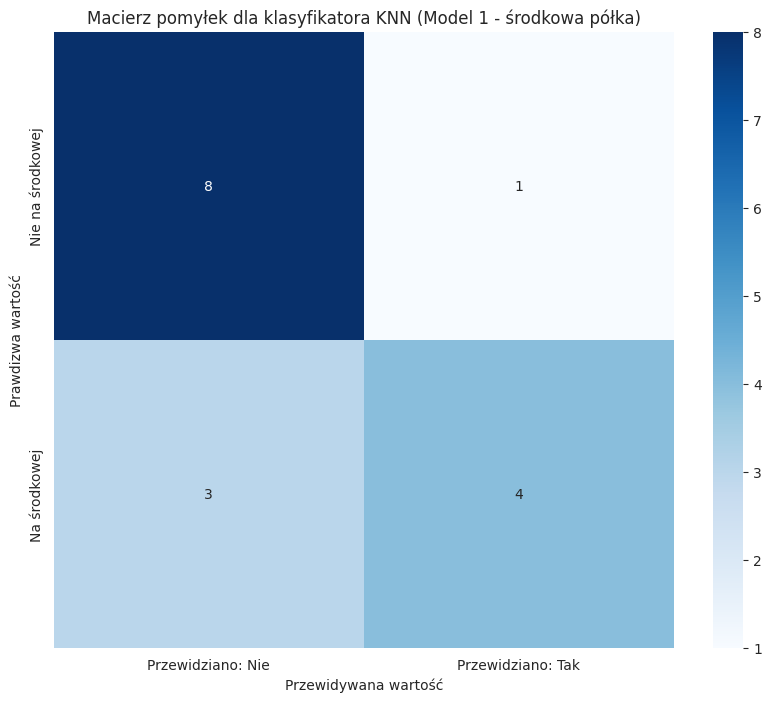


=== Klasyfikator: Naive Bayes ===

Wyniki walidacji krzyżowej dla klasyfikatora Naive Bayes (Model 1 - środkowa półka): 0.804 (±0.037)

=== Wyniki klasyfikacji dla Naive Bayes (Model 1 - środkowa półka) (zbior testowy) ===
              precision    recall  f1-score   support

           0       0.62      0.89      0.73         9
           1       0.67      0.29      0.40         7

    accuracy                           0.62        16
   macro avg       0.64      0.59      0.56        16
weighted avg       0.64      0.62      0.58        16


=== Metryki klasyfikacji Naive Bayes (Model 1 - środkowa półka) ===
Podstawowe metryki:
- Dokładność (Accuracy) = 0.625
- Precyzja (Precision) = 0.667
- Czułość (Recall/Sensitivity) = 0.286
- Swoistość (Specificity) = 0.889
- F1 Score = 0.400

Zaawansowane metryki:
- Matthews Correlation Coefficient (MCC) = 0.222
- Balanced Accuracy = 0.587
- Informedness (Youden's J) = 0.175
- Markedness = 0.556

Wartości macierzy pomyłek:
- True Negatives (TN

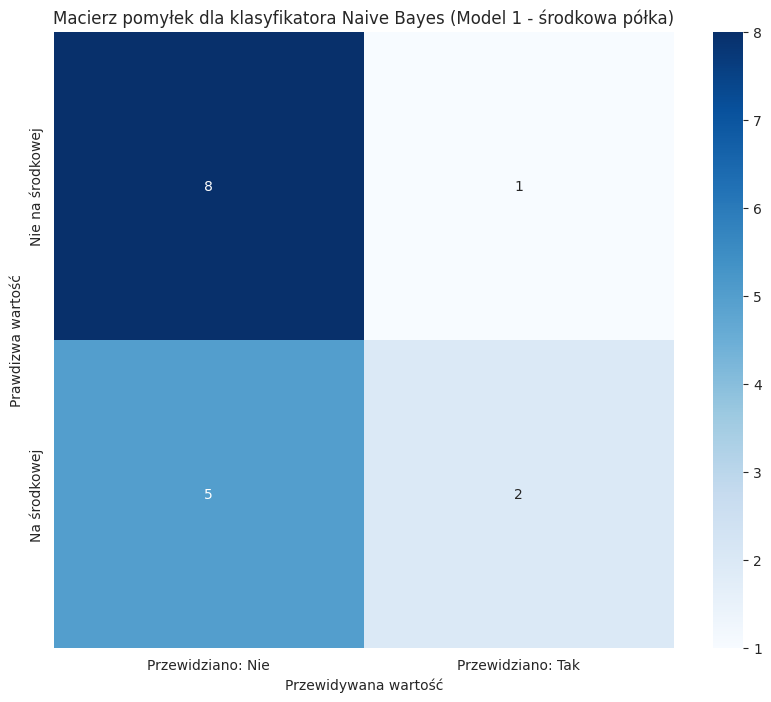

In [36]:
print("\n=== Model 1: Klasyfikacja dla półki środkowej (cukier i kalorie) ===")
X_simple = df[['cukry', 'kalorie']]
y_middle = (df['polka_2'] == 1).astype(int)  # Klasyfikacja dla półki środkowej

# Podzial 80/20 na zbior treningowy i testowy
X_train_simple, X_test_simple, y_train_middle, y_test_middle = train_test_split(
    X_simple,
    y_middle,
    test_size=0.2,
    random_state=42,
    # stratify=y_middle,
)

# Standaryzacja danych 
scaler_simple = StandardScaler()
scaler_simple.fit(X_train_simple)  # Fit tylko na zbiorze treningowym
X_train_simple_scaled = scaler_simple.transform(X_train_simple)
X_test_simple_scaled = scaler_simple.transform(X_test_simple)

# Inicjalizacja klasyfikatorów
classifiers_simple = {
    'Random Forest': RandomForestClassifier(n_estimators=500, random_state=42), # try also min_samples_leaf=2
    'KNN': KNeighborsClassifier(n_neighbors=5), # try also n_neighbors=3, i weights='distance'
    'Naive Bayes': GaussianNB() # var_smoothing=1e-8
}

# Trenowanie i ewaulacja klasyfikatora dla prostego modelu
results_simple = {}
for name, clf in classifiers_simple.items():
    print(f"\n=== Klasyfikator: {name} ===")
    trained_clf, metrics = train_and_evaluate_classifier(
        clf,
        X_train_simple_scaled,  # zbiór treningowy
        X_test_simple_scaled,  # zbiór testowy
        y_train_middle,  # etykiety treningowe
        y_test_middle,  # etykiety testowe
        f"{name} (Model 1 - środkowa półka)",
        is_simple_model=True
    )
    results_simple[name] = metrics


### Wizualizacja porównawcza dla prostego modelu (środkowa półka). Prosty model czyli ten gdzie to MY wybieramy zmienne niezalezne 

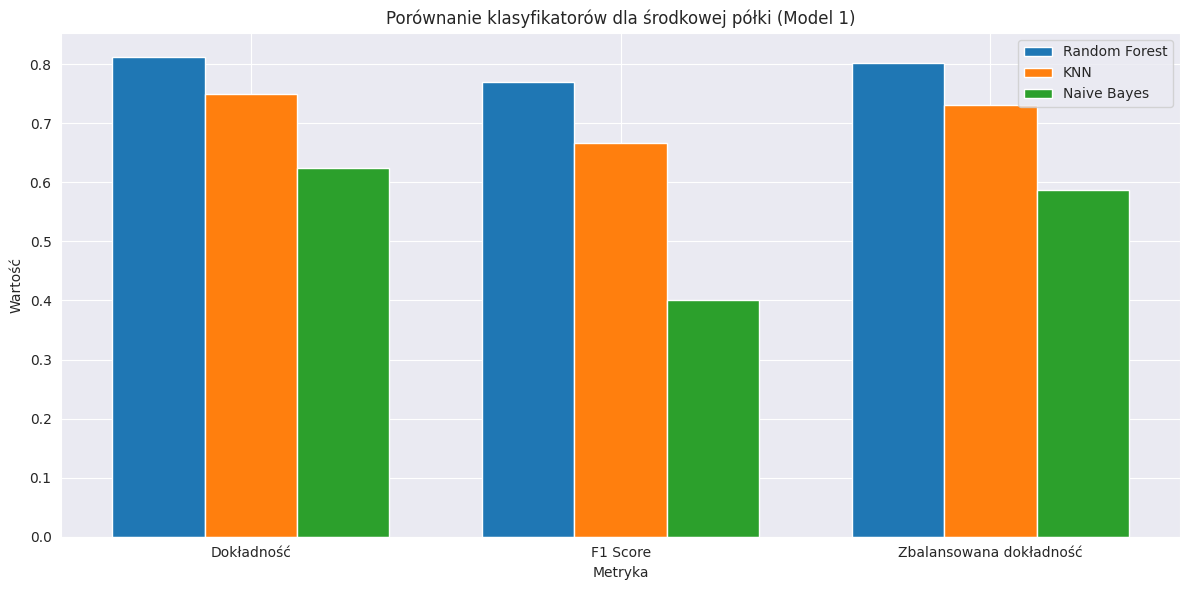

In [37]:
# Wizualizacja porównawcza dla prostego modelu (środkowa półka)
metrics_to_plot = ['accuracy', 'f1_score', 'balanced_accuracy']
metrics_labels = ['Dokładność', 'F1 Score', 'Zbalansowana dokładność']

plt.figure(figsize=(12, 6))
x = np.arange(len(metrics_to_plot))
width = 0.25

for i, (clf_name, metrics) in enumerate(results_simple.items()):
    values = [metrics[metric] for metric in metrics_to_plot]
    plt.bar(x + i * width, values, width, label=clf_name)

plt.xlabel('Metryka')
plt.ylabel('Wartość')
plt.title('Porównanie klasyfikatorów dla środkowej półki (Model 1)')
plt.xticks(x + width, metrics_labels)
plt.legend()
plt.tight_layout()
plt.show()

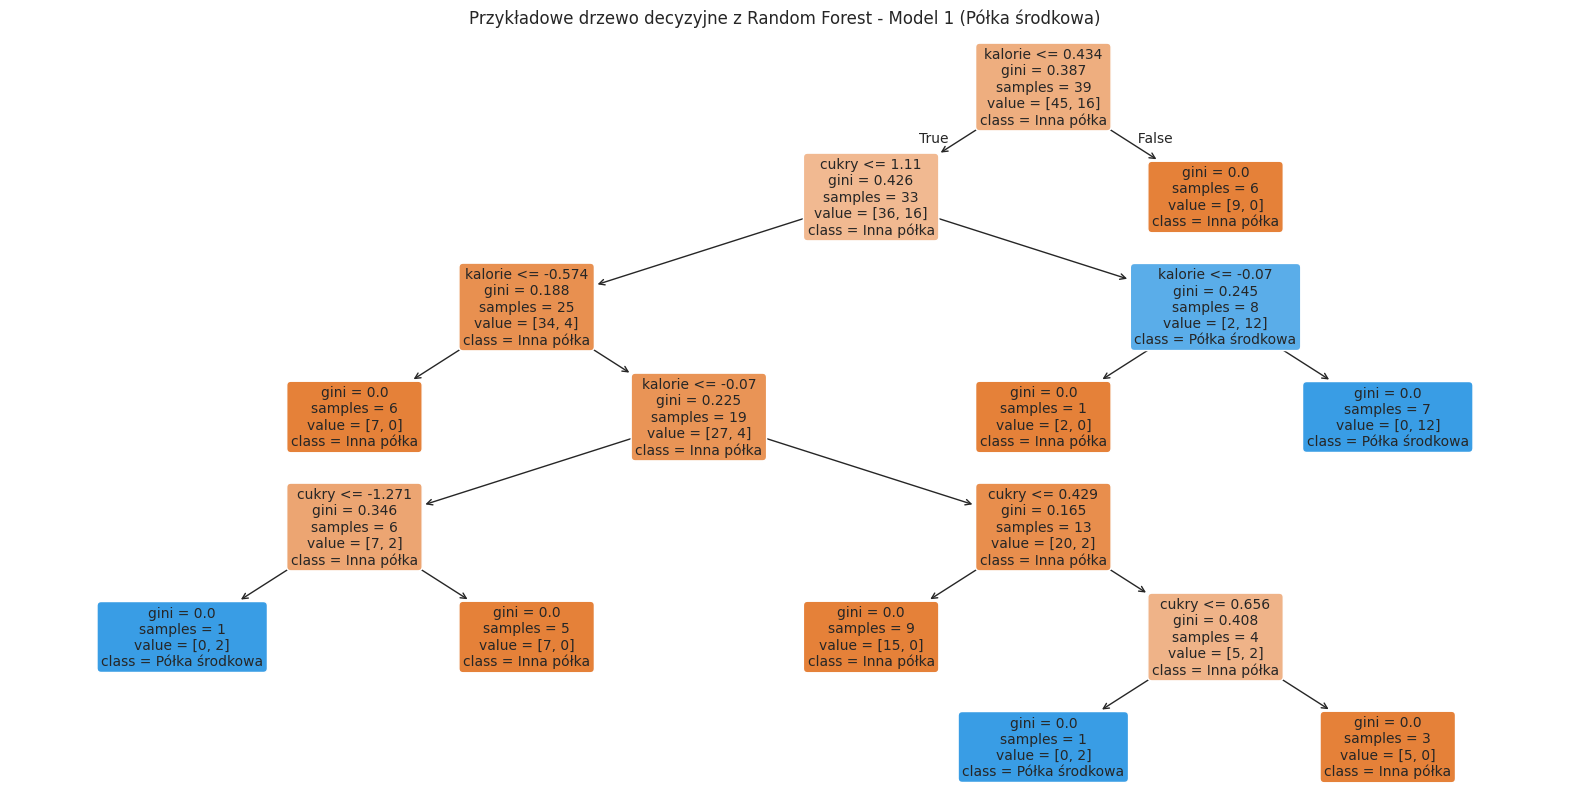

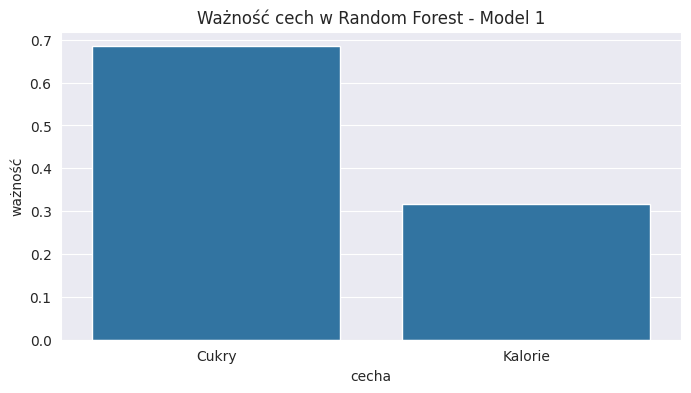

In [45]:
from sklearn.tree import plot_tree

# Po trenowaniu Random Forest dla modelu 1
rf_classifier = classifiers_simple['Random Forest']
plt.figure(figsize=(20,10))
sample_tree = rf_classifier.estimators_[0]  # Bierzemy pierwsze drzewo z lasu
plot_tree(sample_tree, 
          feature_names=['cukry', 'kalorie'],
          class_names=['Inna półka', 'Półka środkowa'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Przykładowe drzewo decyzyjne z Random Forest - Model 1 (Półka środkowa)')
plt.show()

# Dodajmy też wizualizację ważności cech
plt.figure(figsize=(8,4))
importances = pd.DataFrame({
    'cecha': ['Cukry', 'Kalorie'],
    'ważność': rf_classifier.feature_importances_
})
sns.barplot(data=importances, x='cecha', y='ważność')
plt.title('Ważność cech w Random Forest - Model 1')
plt.show()

### Wizualizacja mapy decyzyjnej dla KNN i GaussianNB

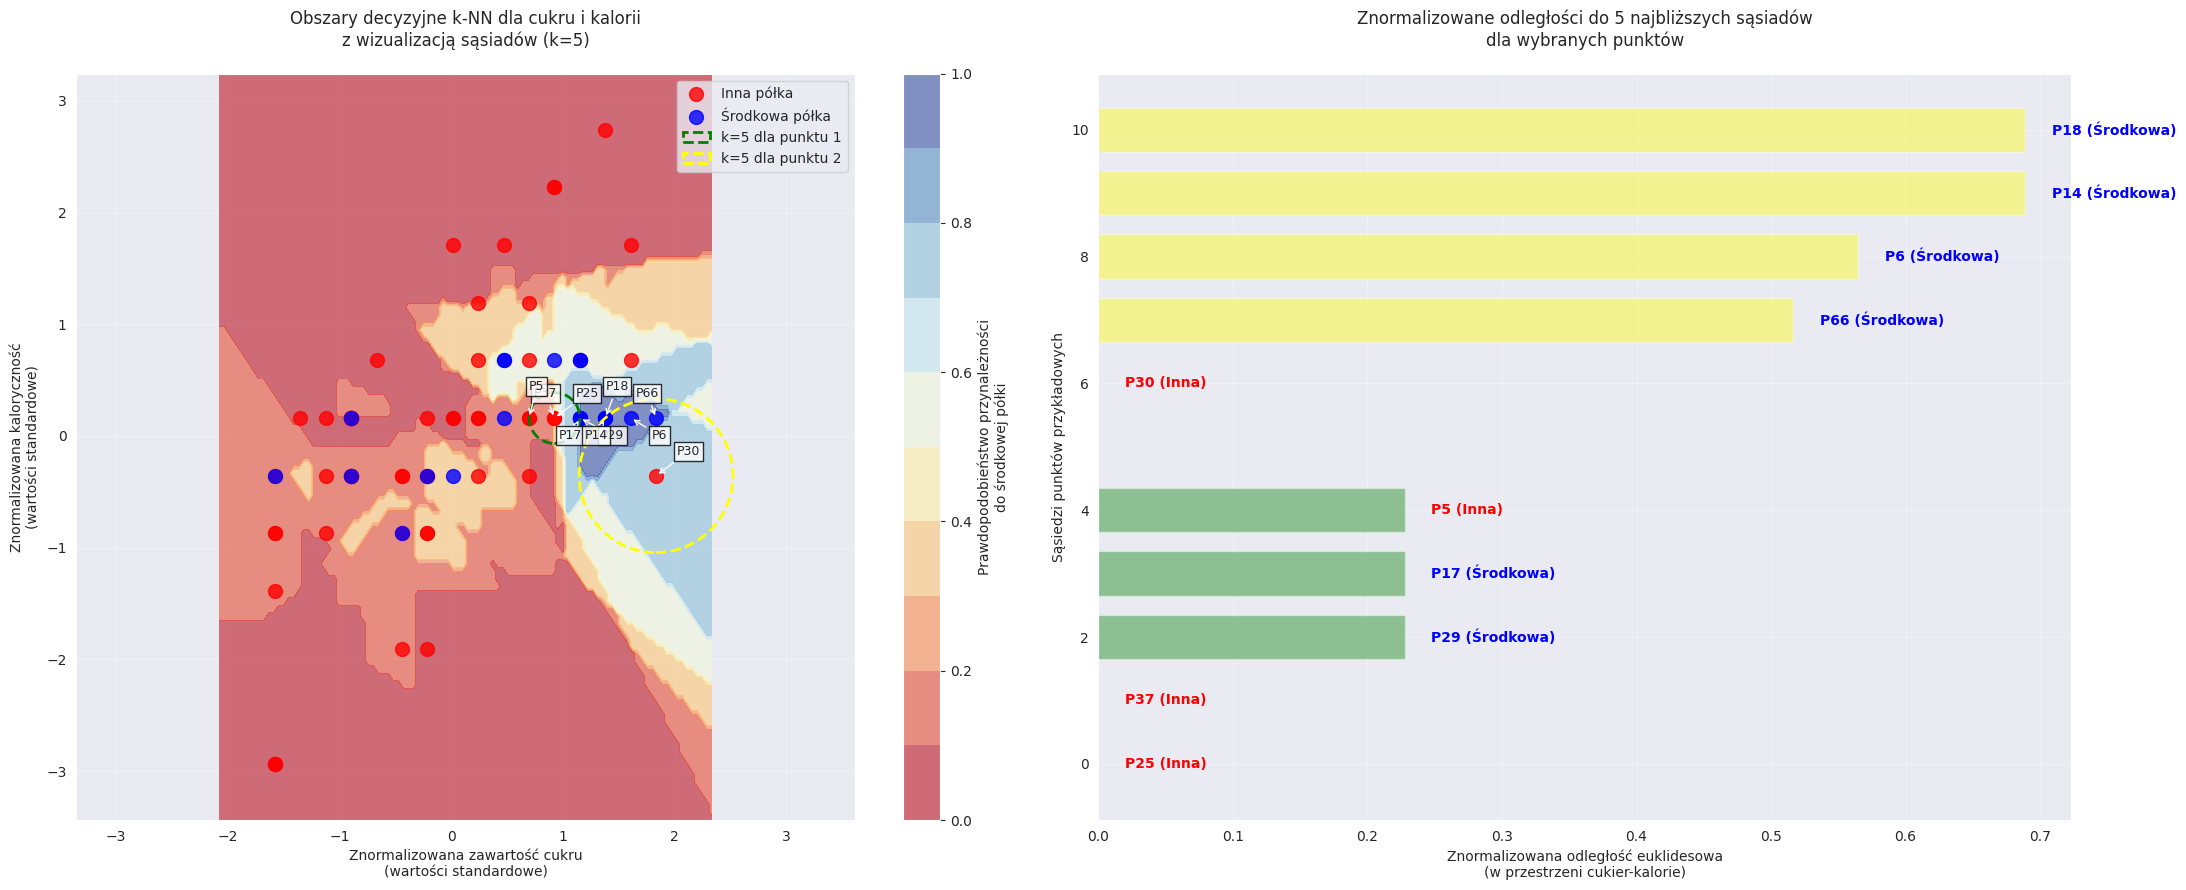

In [66]:
def plot_enhanced_knn_visualization():
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_simple)
    X_scaled_df = pd.DataFrame(X_scaled, columns=['cukry', 'kalorie'])

    # Utworzenie wykresu z większym rozmiarem i lepszymi proporcjami
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 9))
    
    # Przygotowanie danych do mapy decyzyjnej
    x_min, x_max = X_scaled_df['cukry'].min() - 0.5, X_scaled_df['cukry'].max() + 0.5
    y_min, y_max = X_scaled_df['kalorie'].min() - 0.5, X_scaled_df['kalorie'].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                        np.linspace(y_min, y_max, 100))

    # Trenowanie klasyfikatora
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_scaled, y_middle)
    
    # Mapa prawdopodobieństwa z lepszą kolorystyką
    Z = knn.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    
    # Ulepszona mapa decyzyjna
    contour = ax1.contourf(xx, yy, Z, levels=np.linspace(0, 1, 11), 
                          alpha=0.6, cmap='RdYlBu')
    
    # Punkty danych z lepszą widocznością
    scatter1 = ax1.scatter(X_scaled_df['cukry'][y_middle == 0], 
                          X_scaled_df['kalorie'][y_middle == 0],
                          c='red', label='Inna półka', alpha=0.8, s=100)
    scatter2 = ax1.scatter(X_scaled_df['cukry'][y_middle == 1], 
                          X_scaled_df['kalorie'][y_middle == 1],
                          c='blue', label='Środkowa półka', alpha=0.8, s=100)

    example_points_indices = [25, 30]
    colors = ['green', 'yellow']
    
    # Analiza punktów z lepszym oznakowaniem
    for idx, point_idx in enumerate(example_points_indices):
        example_point = X_scaled_df.iloc[point_idx]
        distances, indices = knn.kneighbors([example_point])
        
        # Ulepszone okręgi k-NN
        circle = plt.Circle((example_point['cukry'], example_point['kalorie']), 
                          distances[0].max(), 
                          fill=False, 
                          linestyle='--', 
                          color=colors[idx],
                          linewidth=2,
                          label=f'k=5 dla punktu {idx+1}')
        ax1.add_artist(circle)
        
        # Lepsze etykietowanie punktów
        offsets = [(15, 15), (-15, 15), (15, -15), (-15, -15), (0, 20)]
        for i, (neighbor_idx, offset) in enumerate(zip(indices[0], offsets)):
            neighbor_point = X_scaled_df.iloc[neighbor_idx]
            ax1.annotate(f'P{neighbor_idx}', 
                        (neighbor_point['cukry'], neighbor_point['kalorie']),
                        xytext=offset,
                        textcoords='offset points',
                        bbox=dict(facecolor='white', 
                                edgecolor='black',
                                alpha=0.8,
                                pad=2),
                        fontsize=9,
                        arrowprops=dict(arrowstyle='->'))

        # Ulepszony wykres słupkowy
        y_positions = np.arange(len(indices[0])) + idx * 6
        bars = ax2.barh(y_positions, 
                       distances[0],
                       color=colors[idx], 
                       alpha=0.4,
                       label=f'Punkt {idx+1}',
                       height=0.7)
        
        # Ulepszone etykiety słupków
        for i, (n_idx, dist) in enumerate(zip(indices[0], distances[0])):
            is_middle = y_middle.iloc[n_idx]
            label_color = 'blue' if is_middle else 'red'
            ax2.text(dist + 0.02, y_positions[i],
                    f'P{n_idx} ({"Środkowa" if is_middle else "Inna"})',
                    va='center',
                    color=label_color,
                    fontweight='bold')

    # Ulepszone ustawienia wykresów
    ax1.set_xlabel('Znormalizowana zawartość cukru\n(wartości standardowe)', fontsize=10)
    ax1.set_ylabel('Znormalizowana kaloryczność\n(wartości standardowe)', fontsize=10)
    ax1.set_title('Obszary decyzyjne k-NN dla cukru i kalorii\nz wizualizacją sąsiadów (k=5)', 
                  fontsize=12, pad=20)
    ax1.legend(loc='upper right', bbox_to_anchor=(1, 1))
    ax1.grid(True, alpha=0.3)
    ax1.axis('equal')
    
    ax2.set_title('Znormalizowane odległości do 5 najbliższych sąsiadów\ndla wybranych punktów', 
                  fontsize=12, pad=20)
    ax2.set_xlabel('Znormalizowana odległość euklidesowa\n(w przestrzeni cukier-kalorie)', 
                  fontsize=10)
    ax2.set_ylabel('Sąsiedzi punktów przykładowych', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # Dodanie kolorowej skali
    cbar = plt.colorbar(contour, ax=ax1)
    cbar.set_label('Prawdopodobieństwo przynależności\ndo środkowej półki', 
                   fontsize=10)
    
    plt.tight_layout()
    plt.show()
plot_enhanced_knn_visualization()

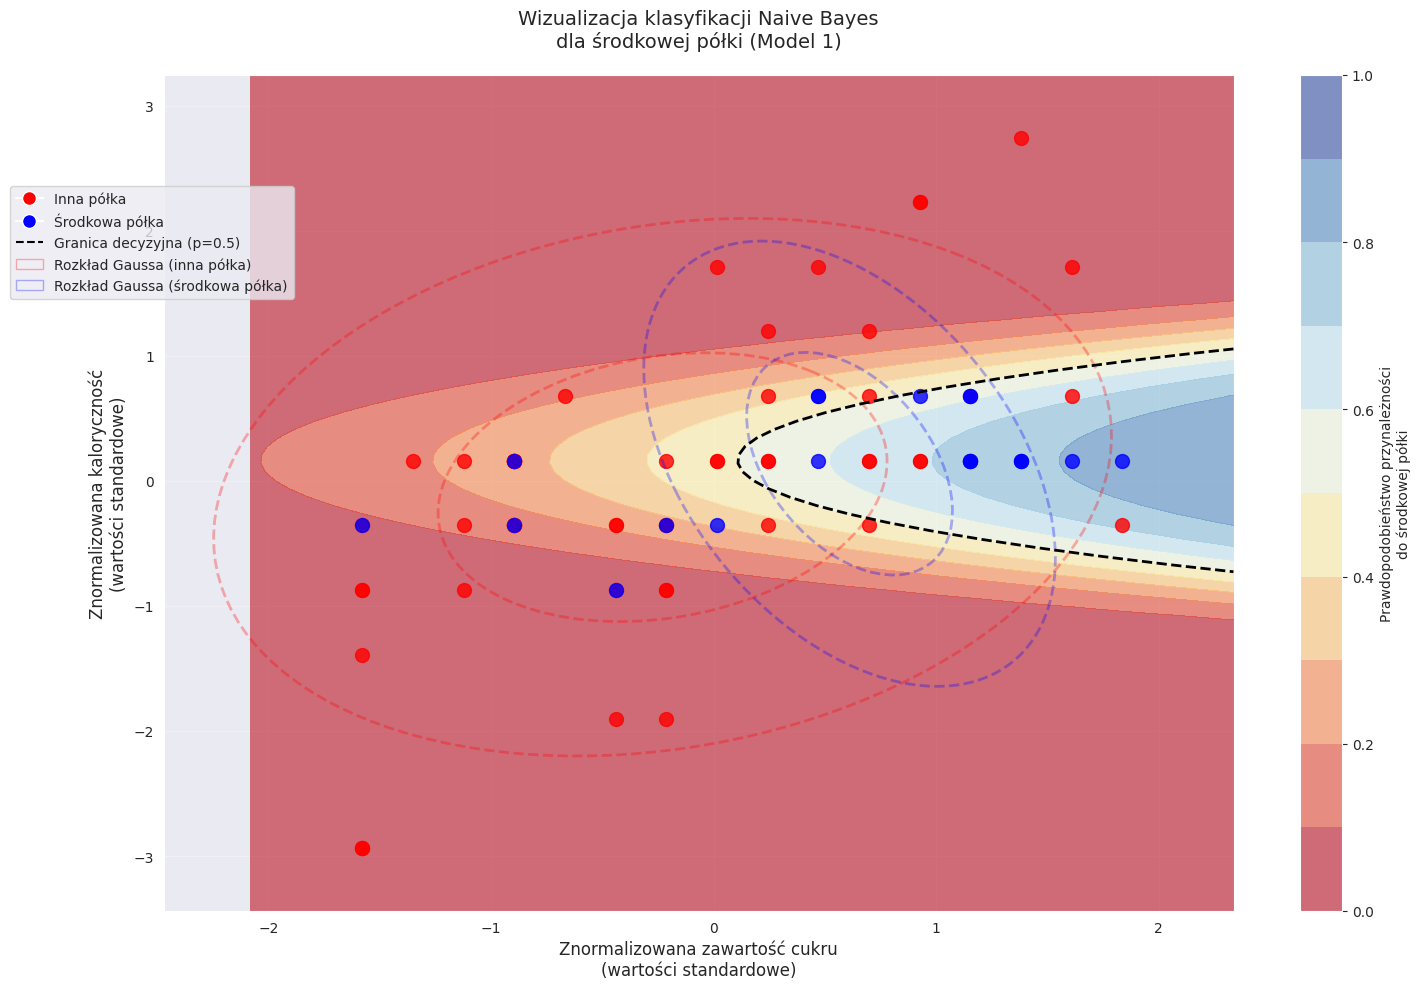

In [70]:
from matplotlib import patches


def plot_naive_bayes_visualization():
    # Przygotowanie danych
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_simple)
    X_scaled_df = pd.DataFrame(X_scaled, columns=['cukry', 'kalorie'])

    # Utworzenie wykresu
    plt.figure(figsize=(15, 10))
    
    # Przygotowanie siatki punktów do wizualizacji
    x_min, x_max = X_scaled_df['cukry'].min() - 0.5, X_scaled_df['cukry'].max() + 0.5
    y_min, y_max = X_scaled_df['kalorie'].min() - 0.5, X_scaled_df['kalorie'].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                        np.linspace(y_min, y_max, 100))

    # Trenowanie klasyfikatora
    nb = GaussianNB()
    nb.fit(X_scaled, y_middle)
    
    # Obliczenie prawdopodobieństw dla siatki punktów
    Z = nb.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    
    # Tworzenie mapy decyzyjnej
    contour = plt.contourf(xx, yy, Z, levels=np.linspace(0, 1, 11), 
                          alpha=0.6, cmap='RdYlBu')
    
    # Dodanie punktów danych
    plt.scatter(X_scaled_df['cukry'][y_middle == 0], 
               X_scaled_df['kalorie'][y_middle == 0],
               c='red', label='Inna półka', alpha=0.8, s=100)
    plt.scatter(X_scaled_df['cukry'][y_middle == 1], 
               X_scaled_df['kalorie'][y_middle == 1],
               c='blue', label='Środkowa półka', alpha=0.8, s=100)

    # Dodanie granic decyzyjnych
    plt.contour(xx, yy, Z, [0.5], colors='k', linewidths=2, linestyles='--')
    
    # Wizualizacja rozkładów Gaussa dla każdej klasy
    for i, (label, color) in enumerate([('Inna półka', 'red'), ('Środkowa półka', 'blue')]):
        mask = y_middle == i
        mu = np.mean(X_scaled[mask], axis=0)
        std = np.std(X_scaled[mask], axis=0)
        
        # Rysowanie elips reprezentujących rozkłady
        eigenvals, eigenvecs = np.linalg.eigh(np.cov(X_scaled[mask].T))
        angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))
        
        for n_std in [1, 2]:
            ell = patches.Ellipse(mu, 2*n_std*std[0], 2*n_std*std[1],
                                angle=angle, fill=False, 
                                color=color, alpha=0.3,
                                linestyle='--', linewidth=2)
            plt.gca().add_patch(ell)

    # Ulepszenie wyglądu wykresu
    plt.xlabel('Znormalizowana zawartość cukru\n(wartości standardowe)', fontsize=12)
    plt.ylabel('Znormalizowana kaloryczność\n(wartości standardowe)', fontsize=12)
    plt.title('Wizualizacja klasyfikacji Naive Bayes\ndla środkowej półki (Model 1)', 
              fontsize=14, pad=20)
    
    # Dodanie legendy z opisem elementów
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                  markersize=10, label='Inna półka'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
                  markersize=10, label='Środkowa półka'),
        plt.Line2D([0], [0], color='k', linestyle='--', 
                  label='Granica decyzyjna (p=0.5)'),
        patches.Patch(facecolor='none', edgecolor='red', alpha=0.3,
                     label='Rozkład Gaussa (inna półka)'),
        patches.Patch(facecolor='none', edgecolor='blue', alpha=0.3,
                     label='Rozkład Gaussa (środkowa półka)')
    ]
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(-0.15, 0.8))
    
    # Dodanie paska kolorów
    colorbar = plt.colorbar(contour)
    colorbar.set_label('Prawdopodobieństwo przynależności\ndo środkowej półki', 
                      fontsize=10)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Wywołanie funkcji
plot_naive_bayes_visualization()

## Model 2: Klasyfikacja dla wszystkich polek i wybor optymalny cech

In [38]:
print("\n=== Model 2: Klasyfikacja dla poszczególnych półek ===")
features = ['kalorie', 'cukry', 'weglowodany', 'proteiny', 'tluszcz', 'blonnik', 'sod', 'potas']
X_full = df[features]

# Podział danych i etykiet dla każdej półki
shelf_splits = {}
for shelf in ['polka_1', 'polka_2', 'polka_3']:
    y_shelf = (df[shelf] == 1).astype(int)
    # Używamy tego samego random_state dla spójności
    X_train, X_test, y_train, y_test = train_test_split(
        X_full, y_shelf, test_size=0.25, random_state=42, stratify=y_shelf
    )
    shelf_splits[shelf] = (X_train, X_test, y_train, y_test)

# Standaryzacja danych
scaler_full = StandardScaler()
scaler_full.fit(shelf_splits['polka_1'][0])  # Fit na pierwszym zbiorze treningowym

# Inicjalizacja słowników wyników
results_full = {'polka_1': {}, 'polka_2': {}, 'polka_3': {}}

# Analiza każdej półki
for shelf_num, shelf in enumerate(['polka_1', 'polka_2', 'polka_3'], 1):
    print(f"\n=== Analiza półki {shelf_num} ===")
    
    # Pobranie odpowiednich zbiorów danych
    X_train, X_test, y_train, y_test = shelf_splits[shelf]
    
    # Standaryzacja
    X_train_scaled = scaler_full.transform(X_train)
    X_test_scaled = scaler_full.transform(X_test)

    # Wybór cech na danych treningowych
    selector = SelectFromModel(RandomForestClassifier(n_estimators=500, random_state=42))
    selector.fit(X_train_scaled, y_train)
    selected_mask = selector.get_support()

    # Wyświetlenie wybranych cech
    selected_features = [feat for feat, selected in zip(features, selected_mask) if selected]
    print(f"Wybrane cechy dla półki {shelf_num}: {selected_features}")

    # Trenowanie i ewaluacja klasyfikatorów
    X_train_selected = X_train_scaled[:, selected_mask]
    X_test_selected = X_test_scaled[:, selected_mask]
    
    for name in classifiers_simple.keys():
        if name == 'Random Forest':
            clf = RandomForestClassifier(n_estimators=500, random_state=42)
        elif name == 'KNN':
            clf = KNeighborsClassifier(n_neighbors=5, weights='distance')
        else:  # Naive Bayes
            clf = GaussianNB()

        print(f"\n=== Klasyfikator: {name} ===")
        trained_clf, metrics = train_and_evaluate_classifier(
            clf,
            X_train_selected,
            X_test_selected,
            y_train,
            y_test,
            f"{name} (Model 2 - półka {shelf_num})"
        )
        if metrics is not None:
            results_full[shelf][name] = metrics
        else:
            print(f"Pominięto wyniki dla {name} na półce {shelf_num} z powodu błędu")


=== Model 2: Klasyfikacja dla poszczególnych półek ===

=== Analiza półki 1 ===
Wybrane cechy dla półki 1: ['cukry', 'weglowodany', 'sod', 'potas']

=== Klasyfikator: Random Forest ===

Wyniki walidacji krzyżowej dla klasyfikatora Random Forest (Model 2 - półka 1): 0.686 (±0.110)

=== Wyniki klasyfikacji dla Random Forest (Model 2 - półka 1) (zbior testowy) ===
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        15
           1       1.00      0.60      0.75         5

    accuracy                           0.90        20
   macro avg       0.94      0.80      0.84        20
weighted avg       0.91      0.90      0.89        20


=== Metryki klasyfikacji Random Forest (Model 2 - półka 1) ===
Podstawowe metryki:
- Dokładność (Accuracy) = 0.900
- Precyzja (Precision) = 1.000
- Czułość (Recall/Sensitivity) = 0.600
- Swoistość (Specificity) = 1.000
- F1 Score = 0.750

Zaawansowane metryki:
- Matthews Correlation Coefficient (MCC) = 0.7

### Wizualizacja porównawcza dla wszystkich półek (Model 2)

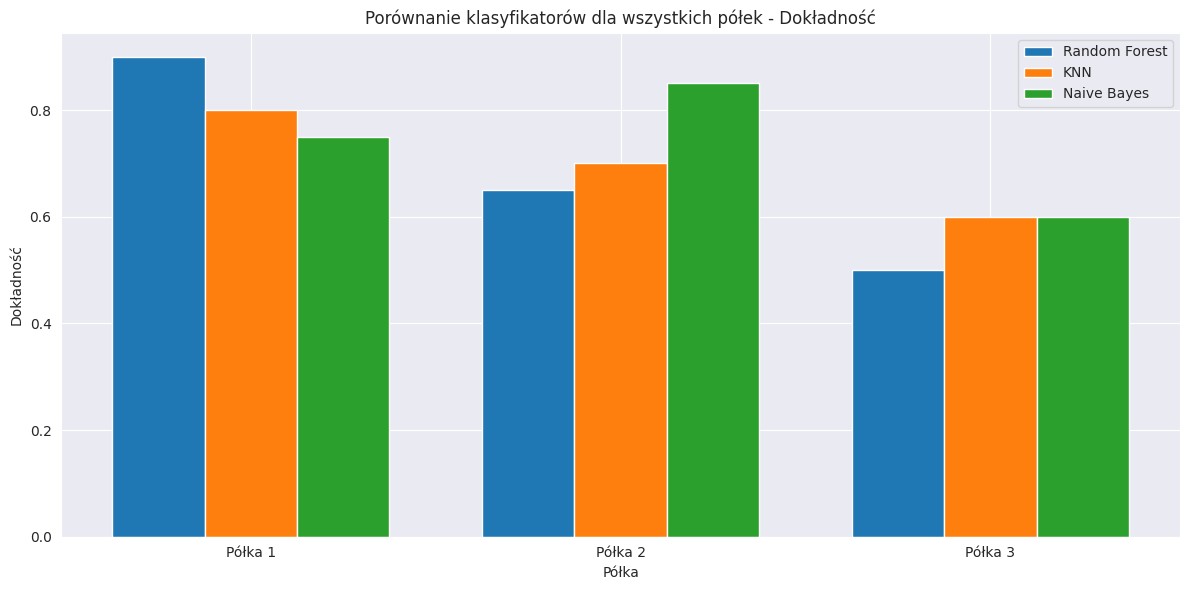

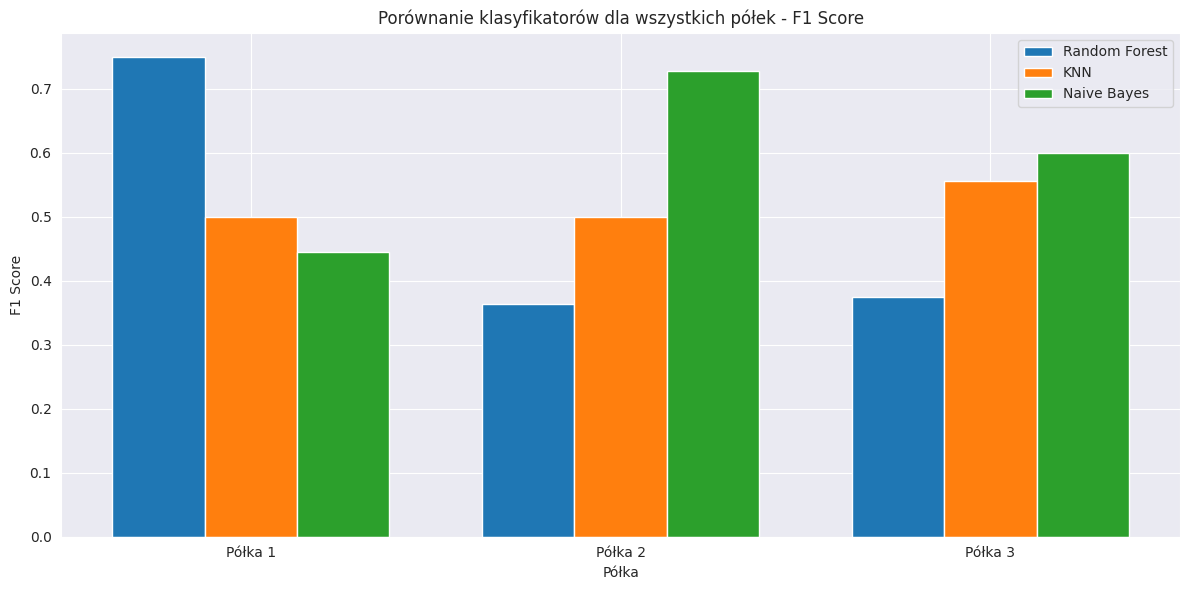

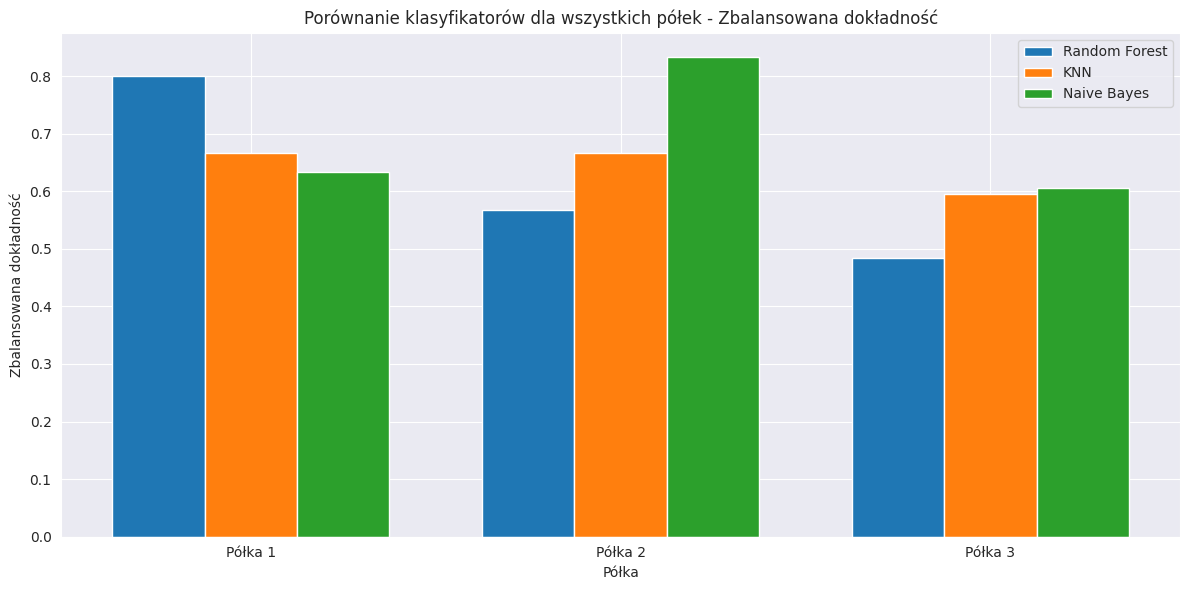

In [39]:
# Wizualizacja porównawcza dla wszystkich półek (Model 2)
for metric in metrics_to_plot:
    plt.figure(figsize=(12, 6))
    x = np.arange(len(results_full))
    width = 0.25

    for i, clf_name in enumerate(classifiers_simple.keys()):
        values = [results_full[shelf][clf_name][metric] for shelf in results_full]
        plt.bar(x + i * width, values, width, label=clf_name)

    plt.xlabel('Półka')
    plt.ylabel(f'{metrics_labels[metrics_to_plot.index(metric)]}')
    plt.title(f'Porównanie klasyfikatorów dla wszystkich półek - {metrics_labels[metrics_to_plot.index(metric)]}')
    plt.xticks(x + width, ['Półka 1', 'Półka 2', 'Półka 3'])
    plt.legend()
    plt.tight_layout()
    plt.show()

### Podsumowanie wynikow tekstowe

In [40]:
# Podsumowanie wyników
print("\n=== Podsumowanie wyników ===")

print("\n++ Model 1 (Środkowa półka): ++")
for clf_name, metrics in results_simple.items():
    print(f"\n{clf_name}:")
    for metric, value in metrics.items():
        print(f"- {metric}: {value:.3f}")

print("\n++ Model 2 (Wszystkie półki): ++")
for shelf in results_full:
    print(f"\nPółka {shelf}:")
    for clf_name, metrics in results_full[shelf].items():
        print(f"\n{clf_name}:")
        for metric, value in metrics.items():
            print(f"- {metric}: {value:.3f}")


=== Podsumowanie wyników ===

++ Model 1 (Środkowa półka): ++

Random Forest:
- accuracy: 0.812
- precision: 0.833
- recall: 0.714
- f1_score: 0.769
- mcc: 0.618
- balanced_accuracy: 0.802

KNN:
- accuracy: 0.750
- precision: 0.800
- recall: 0.571
- f1_score: 0.667
- mcc: 0.493
- balanced_accuracy: 0.730

Naive Bayes:
- accuracy: 0.625
- precision: 0.667
- recall: 0.286
- f1_score: 0.400
- mcc: 0.222
- balanced_accuracy: 0.587

++ Model 2 (Wszystkie półki): ++

Półka polka_1:

Random Forest:
- accuracy: 0.900
- precision: 1.000
- recall: 0.600
- f1_score: 0.750
- mcc: 0.728
- balanced_accuracy: 0.800

KNN:
- accuracy: 0.800
- precision: 0.667
- recall: 0.400
- f1_score: 0.500
- mcc: 0.404
- balanced_accuracy: 0.667

Naive Bayes:
- accuracy: 0.750
- precision: 0.500
- recall: 0.400
- f1_score: 0.444
- mcc: 0.289
- balanced_accuracy: 0.633

Półka polka_2:

Random Forest:
- accuracy: 0.650
- precision: 0.333
- recall: 0.400
- f1_score: 0.364
- mcc: 0.126
- balanced_accuracy: 0.567

KNN:


### Wizualizacja macierzy pomyłek dla wszystkich klasyfikatorów

=== Macierze pomyłek dla wszystkich klasyfikatorów (na zbiorze testowym) ===


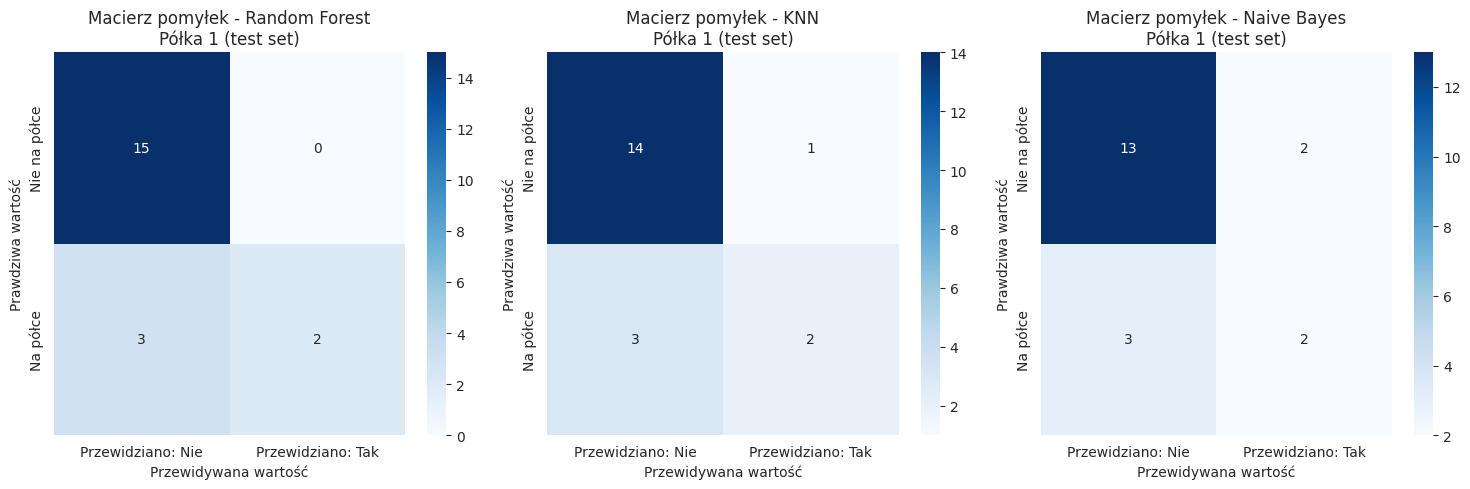

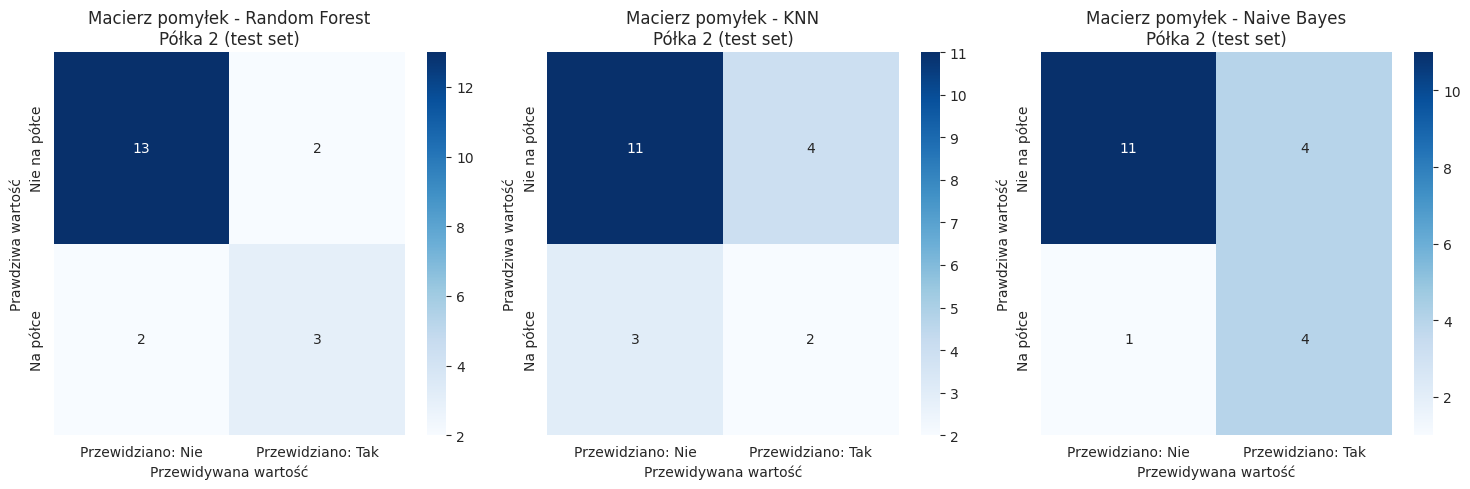

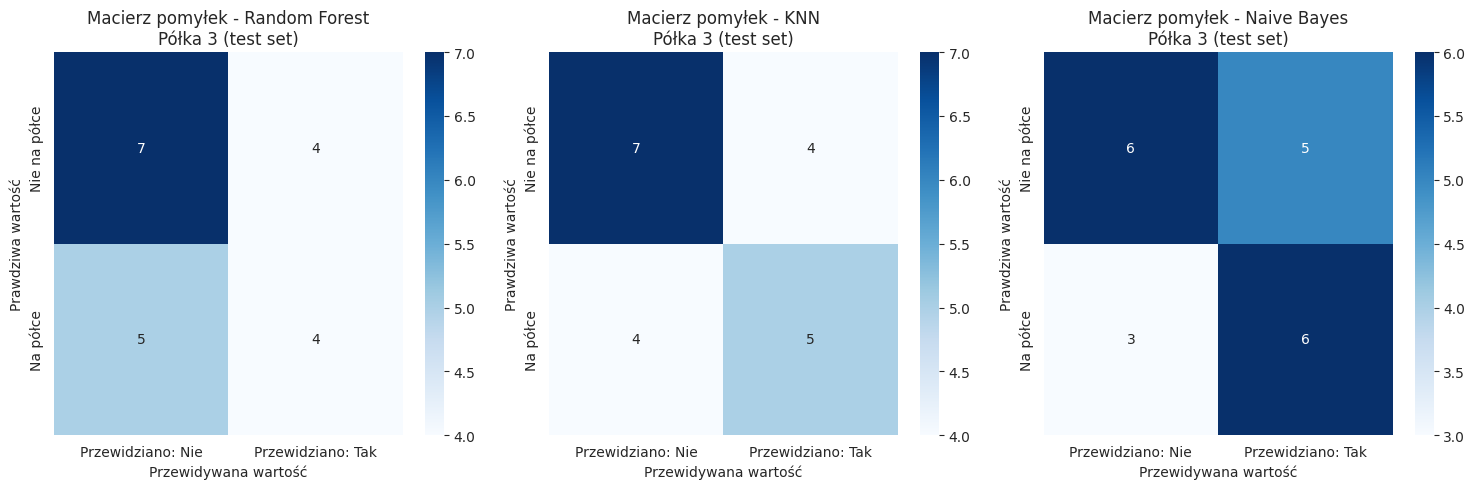

In [41]:
def plot_confusion_matrices():
    for shelf_num, shelf in enumerate(['polka_1', 'polka_2', 'polka_3'], 1):
        plt.figure(figsize=(15, 5))
        
        # Pobranie danych dla danej półki
        X_train, X_test, y_train, y_test = shelf_splits[shelf]
        
        # Standaryzacja
        X_train_scaled = scaler_full.transform(X_train)
        X_test_scaled = scaler_full.transform(X_test)
        
        for i, clf_name in enumerate(classifiers_simple.keys(), 1):
            # Inicjalizacja klasyfikatora
            if clf_name == 'Random Forest':
                clf = RandomForestClassifier(n_estimators=500, min_samples_leaf=2, random_state=42)
            elif clf_name == 'KNN':
                clf = KNeighborsClassifier(n_neighbors=5, weights='distance')
            else:  # Naive Bayes
                clf = GaussianNB()

            # Wybór cech na danych treningowych
            selector = SelectFromModel(RandomForestClassifier(n_estimators=500, min_samples_leaf=2, random_state=42))
            selector.fit(X_train_scaled, y_train)
            selected_mask = selector.get_support()
            
            # Zastosowanie wybranych cech do obu zbiorów
            X_train_selected = X_train_scaled[:, selected_mask]
            X_test_selected = X_test_scaled[:, selected_mask]

            # Trenowanie i predykcja
            clf.fit(X_train_selected, y_train)
            y_pred = clf.predict(X_test_selected)  # Predykcja na zbiorze testowym
            conf_matrix = confusion_matrix(y_test, y_pred)

            # Wizualizacja macierzy pomyłek
            plt.subplot(1, 3, i)
            df_cm = pd.DataFrame(
                conf_matrix,
                index=['Nie na półce', 'Na półce'],
                columns=['Przewidziano: Nie', 'Przewidziano: Tak']
            )
            sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'Macierz pomyłek - {clf_name}\nPółka {shelf_num} (test set)')
            plt.ylabel('Prawdziwa wartość')
            plt.xlabel('Przewidywana wartość')

        plt.tight_layout()
        plt.show()

# Generowanie wizualizacji
print("=== Macierze pomyłek dla wszystkich klasyfikatorów (na zbiorze testowym) ===")
plot_confusion_matrices()

### Wizualizacja wag zmiennych


=== Ważność cech dla każdej półki ===


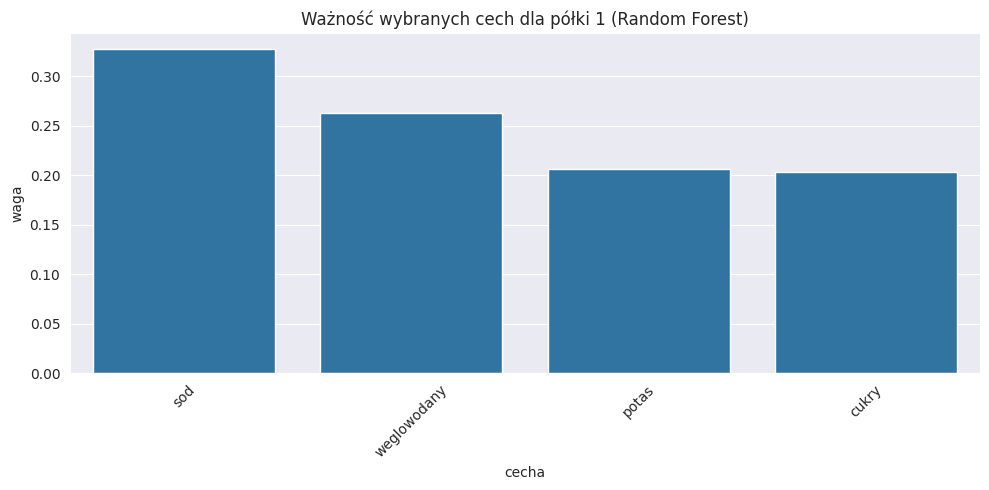

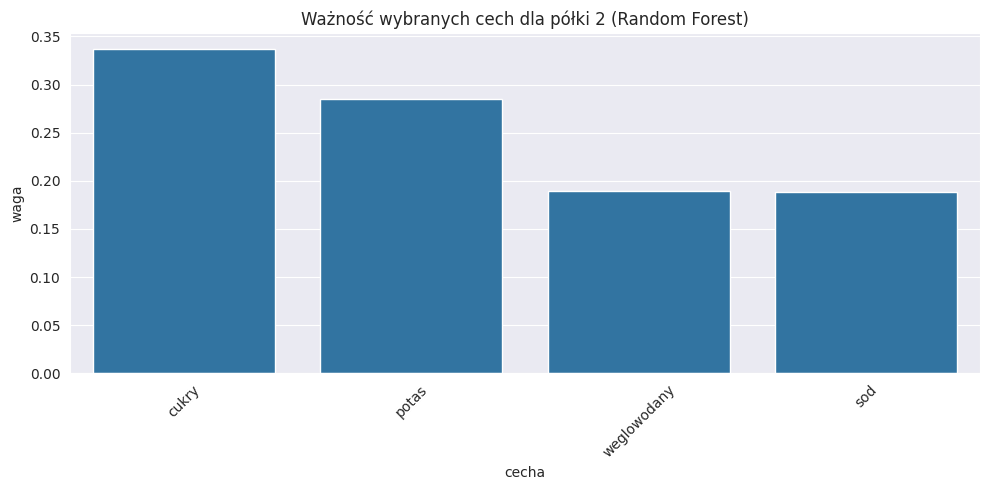

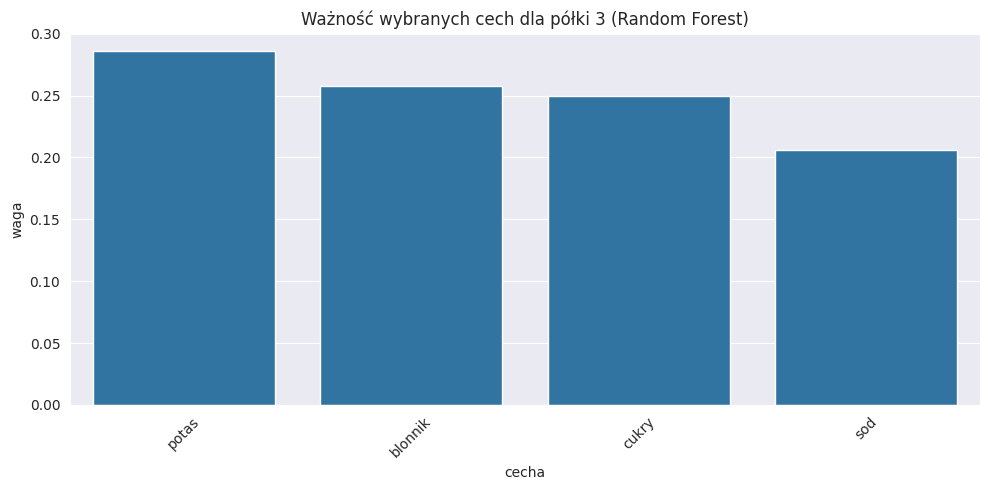

In [42]:
def plot_feature_importance():
    for shelf_num, shelf in enumerate(['polka_1', 'polka_2', 'polka_3'], 1):
        # Pobranie danych dla danej półki
        X_train, X_test, y_train, y_test = shelf_splits[shelf]
        
        # Standaryzacja danych treningowych
        X_train_scaled = scaler_full.transform(X_train)

        # Wybór cech na danych treningowych
        selector = SelectFromModel(RandomForestClassifier(n_estimators=500, random_state=42))
        selector.fit(X_train_scaled, y_train)
        selected_mask = selector.get_support()

        # Wybrane cechy
        selected_features = [feat for feat, selected in zip(features, selected_mask) if selected]

        # Random Forest tylko na wybranych cechach
        rf = RandomForestClassifier(n_estimators=500, min_samples_leaf=2, random_state=42)
        rf.fit(X_train_scaled[:, selected_mask], y_train)

        # Wizualizacja
        plt.figure(figsize=(10, 5))
        feature_importance = pd.DataFrame({
            'cecha': selected_features,
            'waga': rf.feature_importances_
        })
        feature_importance = feature_importance.sort_values('waga', ascending=False)
        sns.barplot(data=feature_importance, x='cecha', y='waga')
        plt.title(f'Ważność wybranych cech dla półki {shelf_num} (Random Forest)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


print("\n=== Ważność cech dla każdej półki ===")
plot_feature_importance()

### Wykres rozmieszczenia płatków z prawdopodobieństwem


=== Mapa decyzyjna dla klasyfikacji środkowej półki ===


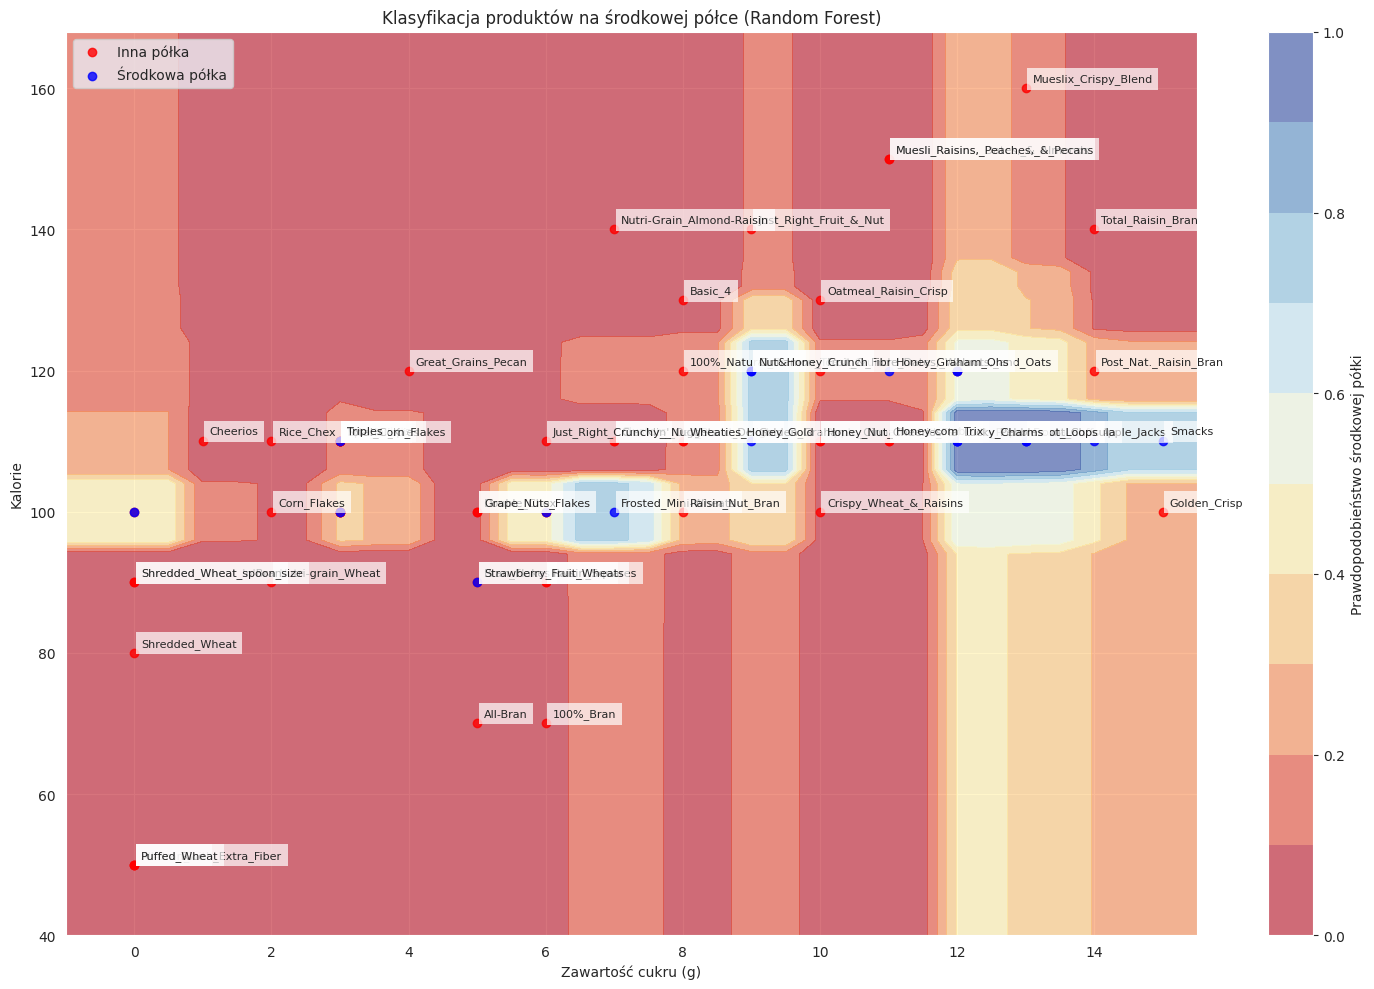

In [43]:
def plot_decision_boundary():
    plt.figure(figsize=(15, 10))

    # Granice decyzyjne dla Random Forest
    x_min, x_max = X_simple['cukry'].min() - 1, X_simple['cukry'].max() + 1  # -1 i +1 to margines
    y_min, y_max = X_simple['kalorie'].min() - 10, X_simple['kalorie'].max() + 10  # -10 i +10 to margines
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5),  # 0.5 to krok
                         np.arange(y_min, y_max, 2))  # 2 to krok

    # Standaryzacja danych
    grid_points = np.c_[xx.ravel(), yy.ravel()]  # Ravel - splaszczanie tablicy\
    grid_points_scaled = scaler_simple.transform(grid_points)  # Standaryzacja danych

    # Predykcja dla każdego punktu
    rf = classifiers_simple['Random Forest']
    Z = rf.predict_proba(grid_points_scaled)[:,
        1]  # Prawdopodobieństwo przynależności do klasy 1 czyli ze jest na srodkowej półce, klasa 0 to ze inna polka
    Z = Z.reshape(xx.shape)

    # Mapa decyzyjna
    plt.contourf(xx, yy, Z, levels=np.linspace(0, 1, 11), alpha=0.6, cmap='RdYlBu')
    plt.colorbar(label='Prawdopodobieństwo środkowej półki')

    # Punkty danych
    plt.scatter(X_simple['cukry'][y_middle == 0], X_simple['kalorie'][y_middle == 0],
                c='red', label='Inna półka', alpha=0.8)
    plt.scatter(X_simple['cukry'][y_middle == 1], X_simple['kalorie'][y_middle == 1],
                c='blue', label='Środkowa półka', alpha=0.8)

    # Etykiety produktów
    for i, row in df.iterrows():
        point_scaled = scaler_simple.transform([[row['cukry'], row['kalorie']]])
        prob = rf.predict_proba(point_scaled)[0][1]
        if prob > 0.7 or prob < 0.3:
            plt.annotate(row['nazwa'],
                         (row['cukry'], row['kalorie']),
                         xytext=(5, 5),
                         textcoords='offset points',
                         fontsize=8,
                         bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

    plt.xlabel('Zawartość cukru (g)')
    plt.ylabel('Kalorie')
    plt.title('Klasyfikacja produktów na środkowej półce (Random Forest)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


print("\n=== Mapa decyzyjna dla klasyfikacji środkowej półki ===")
plot_decision_boundary()